In [3]:
# imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import networkx as nx
# import ndlib.models.ModelConfig as mc
# import ndlib.models.epidemics as ep
# from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from networkx.drawing.nx_agraph import from_agraph
import random
from tabulate import tabulate
from IPython.display import display

# CLS assignment 2: Networked part

In [4]:
# set MPL to render plots by chosing backend
# mpl.use('TkAgg')

# Adjust pandas display settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.float_format', '{:,.3f}'.format)  # Float format to 3 decimal places

In [5]:
# assuming an undirected graph

# parameters

N = 1000 # number of nodes
p = 0.1 # probability link creation
# Example: Creating a simple graph with 1000 nodes and a 0.1 probability of edge creation
g = nx.erdos_renyi_graph(N, p)



In [6]:
# SIR_model_randomgraph = ep.SIRModel(g)

In [7]:
# config = mc.Configuration()
# config.add_model_parameter('beta', 0.002)  # Infection probability
# config.add_model_parameter('gamma', 0.05)  # Recovery probability
# SIR_model_randomgraph.set_initial_status(config)

# # Example: Infecting node 0
# config.add_model_initial_configuration("Infected", 0.05*N)




In [8]:
# iterations = SIR_model_randomgraph.iteration_bunch(200)  # Execute 200 iterations
# trends = SIR_model_randomgraph.build_trends(iterations)

In [9]:
# for iteration, status in enumerate(iterations):
#     print(f"Iteration {iteration}:")
#     print("Node status:", status['status'])
#     print("-----")

In [10]:
# from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

# # Visualize the diffusion trend
# viz = DiffusionTrend(SIR_model_randomgraph, trends)
# viz.plot()
# plt.show()


Writing own simulation functions

In [11]:
def simulate_sir_on_network(N, k=None, network_type='erdos_renyi', p=None, beta=0.002, gamma=0.05, initial_i_proportion=0.1, iterations=200, plot=False, return_network = True, caption=None):
    """
    Simulate the SIR (Susceptible, Infected, Recovered) model on a network and return the proportions of each compartment over time.
    
    Parameters:
    - N (int): Total number of nodes in the network.
    - k (int): Number of nodes each node is connected to.
    - network_type (str): Type of network to be created. Supported types: 'erdos_renyi', 'watts_strogatz', 'barabasi_albert'.
    - p (float, optional): Probability for edge creation (relevant for 'erdos_renyi' and 'watts_strogatz'). Default is None.
    - beta (float): Probability of transmission from an infected to a susceptible node during an interaction. Default is 0.002.
    - gamma (float): Probability of an infected node recovering in one iteration. Default is 0.05.
    - initial_i_proportion (float): Proportion of initially infected nodes. Default is 0.1.
    - iterations (int): Number of iterations for the simulation. Default is 200.
    - graph (bool): Whether to plot the proportions of S, I, R over time. Default is False.
    
    Returns:
    - list: A list of dictionaries with the proportions of 'S', 'I', and 'R' at each iteration.
    
    Raises:
    - ValueError: If an unsupported network type is provided or if the 'p' parameter is missing for certain network types.
    """
    
    # Initialize the network based on the specified network type
    if network_type == 'erdos_renyi':
        if p is None:
            if k:
                p = k/(N - 1)
            elif k is None:  # If k is not provided, calculate it
                k = p * (N - 1)
            else:
                raise ValueError("Either average node degree 'k' or probability of edge creation 'p' parameter is required for the 'erdos_renyi' network type.")
        network = nx.erdos_renyi_graph(N, p)
    elif network_type == 'watts_strogatz':
        if p is None:
            raise ValueError("The 'p' parameter is required for the 'watts_strogatz' network type.")
        network = nx.watts_strogatz_graph(N, k, p)
    elif network_type == 'barabasi_albert':
        network = nx.barabasi_albert_graph(N, k)
    else:
        raise ValueError(f"Unsupported network type: {network_type}")

    # Set initial state for all nodes as Susceptible (S)
    states = {node: 'S' for node in network.nodes()}
    
    # Randomly choose nodes to set as initial Infected (I) state
    initial_infected_nodes = random.sample(list(network.nodes()), int(N * initial_i_proportion))
    for node in initial_infected_nodes:
        states[node] = 'I'
    
    # Track the proportions of S, I, R at each iteration
    trends = [{'S': (N - len(initial_infected_nodes))/N, 'I': len(initial_infected_nodes)/N, 'R': 0}]
    
    # Simulate the SIR model over the specified iterations
    for _ in range(iterations):
        new_states = states.copy()
        for node, state in states.items():
            # If node is infected, it may recover or infect its neighbors
            if state == 'I':
                # Node recovers with probability gamma
                if random.random() < gamma:
                    new_states[node] = 'R'
                    continue
                
                # For each neighbor, it can get infected with probability beta
                neighbors = list(network.neighbors(node))
                for neighbor in neighbors:
                    if new_states[neighbor] == 'S' and random.random() < beta:
                        new_states[neighbor] = 'I'
        
        # Update states for the next iteration
        states = new_states
        
        # Append the proportions of S, I, R to the trends list
        trends.append({'S': list(states.values()).count('S')/N, 
                       'I': list(states.values()).count('I')/N, 
                       'R': list(states.values()).count('R')/N})
    
    # Plot the trends if plot=True
    if plot:
        S = [t['S'] for t in trends]
        I = [t['I'] for t in trends]
        R = [t['R'] for t in trends]
        
        plt.figure(figsize=(10, 6))
        plt.plot(S, label='Susceptible', color='blue')
        plt.plot(I, label='Infected', color='orange')
        plt.plot(R, label='Recovered', color='green')
        plt.xlabel('Iterations')
        plt.ylabel('Proportion of Population')
        plt.title('SIR Model on Network (Proportions)')
        plt.legend()
        plt.figtext(0.5, -0.15, caption, wrap=True, horizontalalignment='center', fontsize=12)
        plt.grid(True)
        plt.show()
    if return_network:
        return trends, network
    else:
        return trends

In [12]:
def multiple_runs_simulation(runs, set_graph=False, G=None, *args, **kwargs):
    """
    Perform multiple runs of the SIR simulation and return the averaged results, standard deviations, and all networks.
    
    Parameters:
    - runs (int): Number of runs for each parameter combination.
    - G (networkx.Graph): A given graph. Only used if set_graph=True.
    - *args, **kwargs: Arguments and keyword arguments to pass to the simulate_sir_on_network function.
    
    Returns:
    - list: A list of dictionaries with the averaged proportions and standard deviations of 'S', 'I', and 'R' at each iteration.
    - networks: List of networks from all simulation runs.
    """
    
    
    all_trends = []
    networks = []  # List to store networks from each run
    

        
    for _ in range(runs):
        if set_graph:
            # For set_graph, we don't need network_type and p, so we create a shallow copy and remove them
            kwargs_copy = kwargs.copy()
            kwargs_copy.pop('network_type', None)
            kwargs_copy.pop('p', None)
            
            # Pass the graph G to the function
            trends, network = simulate_sir_set_graph(G, *args, **kwargs_copy)
        else:
            trends, network = simulate_sir_on_network(*args, **kwargs)
        
        all_trends.append(trends)
        networks.append(network)
        
    avg_trends = []
    std_S = []
    std_I = []
    std_R = []
    
    for i in range(len(all_trends[0])):
        avg_S = sum([t[i]['S'] for t in all_trends]) / runs
        avg_I = sum([t[i]['I'] for t in all_trends]) / runs
        avg_R = sum([t[i]['R'] for t in all_trends]) / runs
        
        sigma_S = (sum([(t[i]['S'] - avg_S)**2 for t in all_trends]) / runs)**0.5
        sigma_I = (sum([(t[i]['I'] - avg_I)**2 for t in all_trends]) / runs)**0.5
        sigma_R = (sum([(t[i]['R'] - avg_R)**2 for t in all_trends]) / runs)**0.5
        
        avg_trends.append({'S': avg_S, 'I': avg_I, 'R': avg_R})
        std_S.append(sigma_S)
        std_I.append(sigma_I)
        std_R.append(sigma_R)
    
    return avg_trends, std_S, std_I, std_R, networks


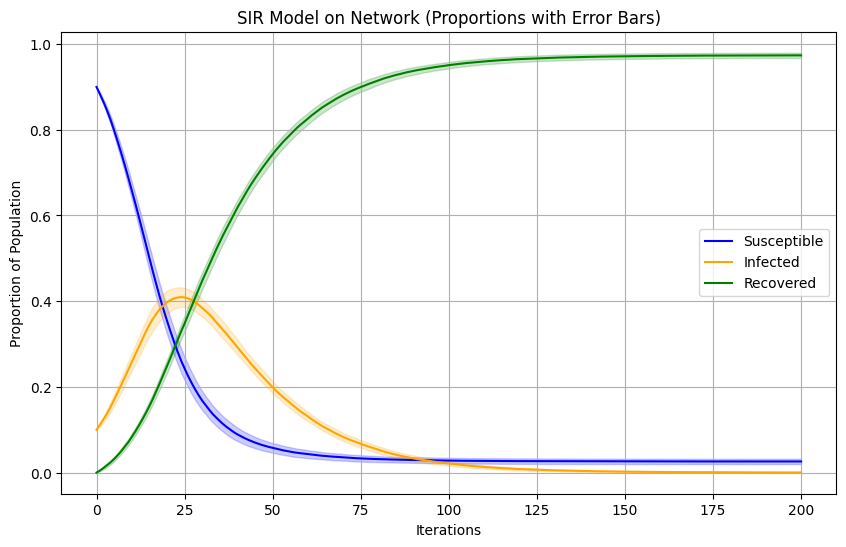

In [13]:
def plot_with_error_bars(avg_trends, std_S, std_I, std_R, caption=None, title= 'SIR Model on Network (Proportions with Error Bars)', plot_index = None, save_fig = True):
    """Plot the average trends with error bars
    
        # Example usage
    N = 1000
    k = 5
    network_type = 'erdos_renyi'
    p = 0.1
    avg_trends, std_S, std_I, std_R = multiple_runs_simulation(100, N, k, network_type=network_type, p=p)
    plot_with_error_bars(avg_trends, std_S, std_I, std_R)
    """	
    
    S = [t['S'] for t in avg_trends]
    I = [t['I'] for t in avg_trends]
    R = [t['R'] for t in avg_trends]
    
    plt.figure(figsize=(10, 6))
    
    # Plot average trends
    plt.plot(S, label='Susceptible', color='blue')
    plt.plot(I, label='Infected', color='orange')
    plt.plot(R, label='Recovered', color='green')
    
    # Fill between for error
    plt.fill_between(range(len(S)), [s - ds for s, ds in zip(S, std_S)], [s + ds for s, ds in zip(S, std_S)], color='blue', alpha=0.2)
    plt.fill_between(range(len(I)), [i - di for i, di in zip(I, std_I)], [i + di for i, di in zip(I, std_I)], color='orange', alpha=0.2)
    plt.fill_between(range(len(R)), [r - dr for r, dr in zip(R, std_R)], [r + dr for r, dr in zip(R, std_R)], color='green', alpha=0.2)
    
    plt.xlabel('Iterations')
    plt.ylabel('Proportion of Population')
    plt.title(title)
    plt.legend()
    if caption:
        plt.figtext(0.5, -0.15, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.grid(True)
    if save_fig:
        plt.savefig(f'{title} {plot_index}.png')
    plt.show()

# Example usage
N = 1000
k = 5
network_type = 'erdos_renyi'
p = 0.1
avg_trends, std_S, std_I, std_R, _ = multiple_runs_simulation(100, N=N, k=k, network_type=network_type, p=p, set_graph=False)
plot_with_error_bars(avg_trends, std_S, std_I, std_R)


In [14]:
def multi_simulate_sir_on_network(N, k=None, network_type='erdos_renyi', p=None, beta=0.002, gamma=0.05, initial_i_proportion=0.1, iterations=200, plot=False, runs=1, title= None):
    """
    Simulate the SIR model on a network for multiple parameter settings and return the results.
    
    Parameters:
    - N (int or list): Total number of nodes in the network or list of such values.
    - k (int or list): Number of nodes each node is connected to or list of such values.
    - network_type (str): Type of network to be created. Supported types: 'erdos_renyi', 'watts_strogatz', 'barabasi_albert'.
    - p (float or list, optional): Probability for edge creation (relevant for 'erdos_renyi' and 'watts_strogatz') or list of such values. Default is None.
    - beta (float or list): Probability of transmission from an infected to a susceptible node during an interaction or list of such values. Default is 0.002.
    - gamma (float or list): Probability of an infected node recovering in one iteration or list of such values. Default is 0.05.
    - initial_i_proportion (float or list): Proportion of initially infected nodes or list of such values. Default is 0.1.
    - iterations (int): Number of iterations for the simulation. Default is 200.
    - graph (bool): Whether to plot the proportions of S, I, R over time for each simulation. Default is False.
    - runs (int): Number of runs for each parameter combination. Default is 1.
    
    Returns:
    - list: A list of dictionaries containing the simulation parameters and the trends of 'S', 'I', and 'R' for each parameter combination.
    """

     # Ensure parameters are in list format for iteration
    N = [N] if not isinstance(N, list) else N
    k = [k] if k is not None and not isinstance(k, list) else k
    p = [p] if p is not None and not isinstance(p, list) else p
    beta = [beta] if not isinstance(beta, list) else beta
    gamma = [gamma] if not isinstance(gamma, list) else gamma
    initial_i_proportion = [initial_i_proportion] if not isinstance(initial_i_proportion, list) else initial_i_proportion
    
    k = k or [None]
    p = p or [None]

    results = []

    for n in N:
        for degree in k:
            for probability in p:
                for b in beta:
                    for g in gamma:
                        for init_inf in initial_i_proportion:

                            params = {
                                    "N": n,
                                    "network_type": network_type,
                                    "p": probability,
                                    "beta": b,
                                    "gamma": g,
                                    "initial_i_proportion": init_inf,
                                    "iterations": iterations
                                }
                            if network_type == 'erdos_renyi':
                                if degree is None:
                                    params["k"] = probability * (n - 1)
                                else:
                                    params["k"] = degree

                            else:
                                params["k"] = degree

                            avg_trends, std_S, std_I, std_R, networks = multiple_runs_simulation(runs, N=n, k=degree, network_type=network_type, p=probability, beta=b, gamma=g, initial_i_proportion=init_inf, iterations=iterations)

                            if plot:
                                caption = ', '.join(f"{key}: {value}" for key, value in params.items())
                                if title:
                                    plot_with_error_bars(avg_trends, std_S, std_I, std_R, caption=caption, title=title)
                                else:
                                    plot_with_error_bars(avg_trends, std_S, std_I, std_R, caption=caption) 

                            results.append({
                                "parameters": params,
                                "avg_trends": avg_trends,
                                "std_S": std_S,
                                "std_I": std_I,
                                "std_R": std_R,
                                "networks": networks
                            })
    return results

Ideas for parameter sets:

1. Random Networks:

Generate random networks with varying probabilities of edge creation (p) to explore the impact of network density on disease spread.

Parameter Set 1: Low Density

N (Number of Nodes): 500
k (Average Degree): 5
p (Probability of Edge Creation): 0.05
Parameter Set 2: Medium Density

N (Number of Nodes): 500
k (Average Degree): 5
p (Probability of Edge Creation): 0.2
Parameter Set 3: High Density

N (Number of Nodes): 500
k (Average Degree): 5
p (Probability of Edge Creation): 0.5

2. Small-World Networks:

Generate small-world networks with varying rewiring probabilities (p) to investigate the impact of network clustering on disease spread.

Parameter Set 4: Low Clustering (High Rewiring)

N (Number of Nodes): 500
k (Average Degree): 5
p (Rewiring Probability): 0.8
Parameter Set 5: Moderate Clustering (Medium Rewiring)

N (Number of Nodes): 500
k (Average Degree): 5
p (Rewiring Probability): 0.4
Parameter Set 6: High Clustering (Low Rewiring)

N (Number of Nodes): 500
k (Average Degree): 5
p (Rewiring Probability): 0.1

3. Scale-Free Networks (Barabási-Albert Model):

Generate scale-free networks using the Barabási-Albert model with varying initial attachment values (m0) to explore the impact of hub formation on disease spread.

Parameter Set 7: Low Hub Formation

N (Number of Nodes): 1000
m0 (Initial Attachment): 2
Parameter Set 8: Moderate Hub Formation

N (Number of Nodes): 1000
m0 (Initial Attachment): 5
Parameter Set 9: High Hub Formation

N (Number of Nodes): 1000
m0 (Initial Attachment): 10


In [15]:
# Parameter sets for multi_simulate_sir_on_network function

# Random Networks
param_set_random_density = {
    "N": [500],
    "network_type": "erdos_renyi",
    "p": [0.05, 0.2, 0.5]  # Varying values for 'p'
}

# Small-World Networks
param_set_small_world_clustering = {
    "N": [500],
    "k": [5],
    "network_type": "watts_strogatz",
    "p": [0.8, 0.4, 0.1]  # Varying values for 'rewiring_prob'
}

# Scale-Free Networks (Barabási-Albert Model)
param_set_scale_free_hub_formation = {
    "N": [1000],
    "k": [2, 5, 10],  # Varying values for 'k'
    "network_type": "barabasi_albert"
}


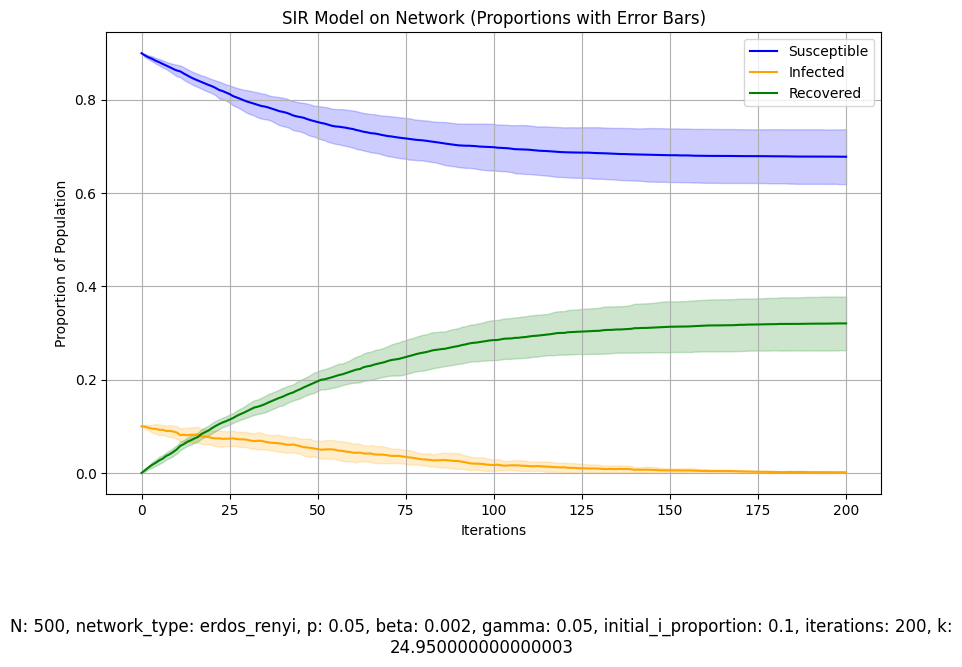

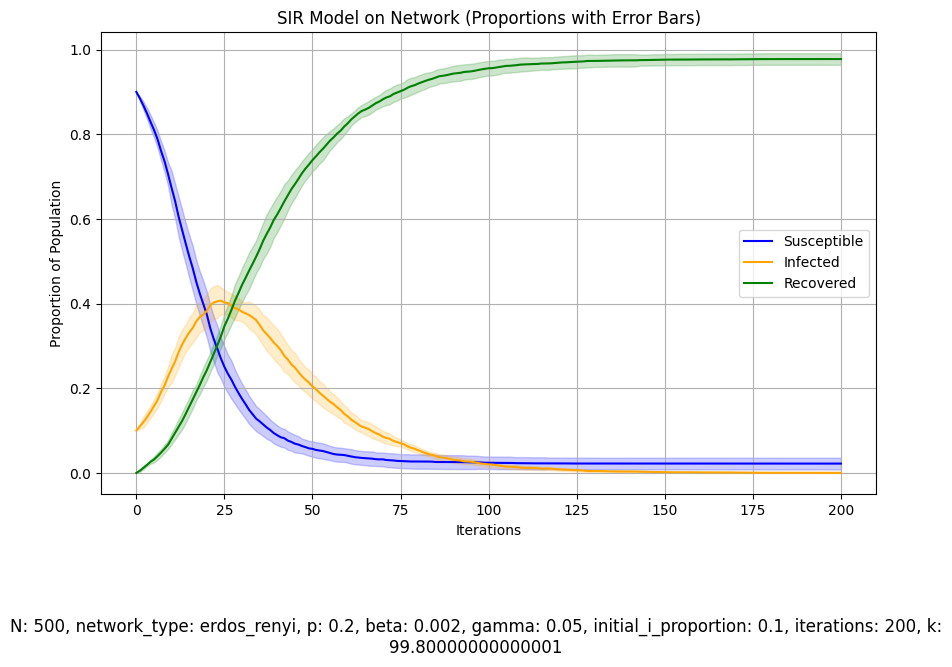

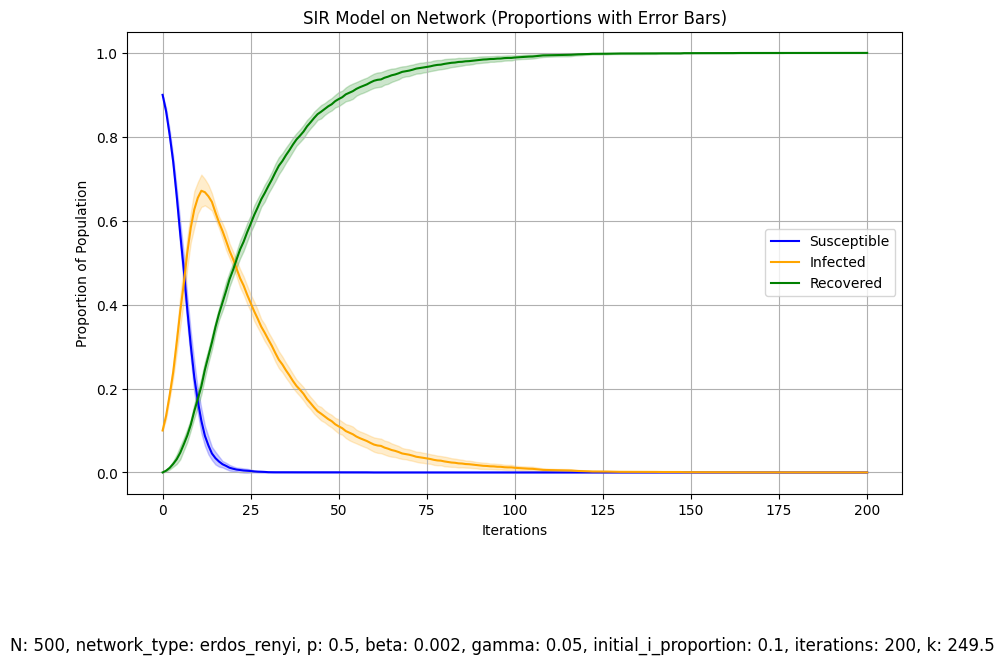

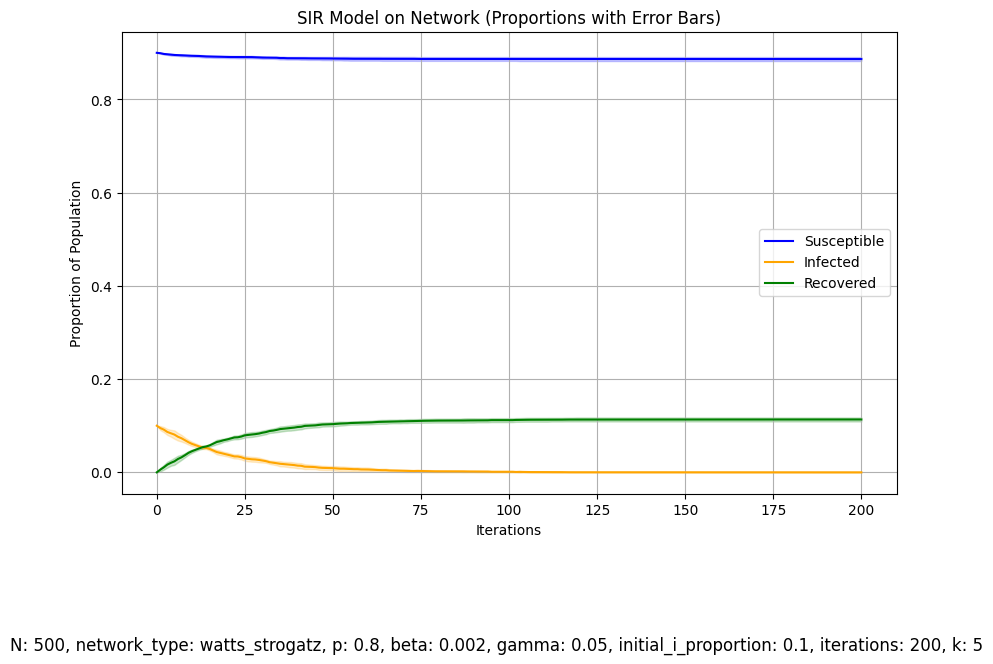

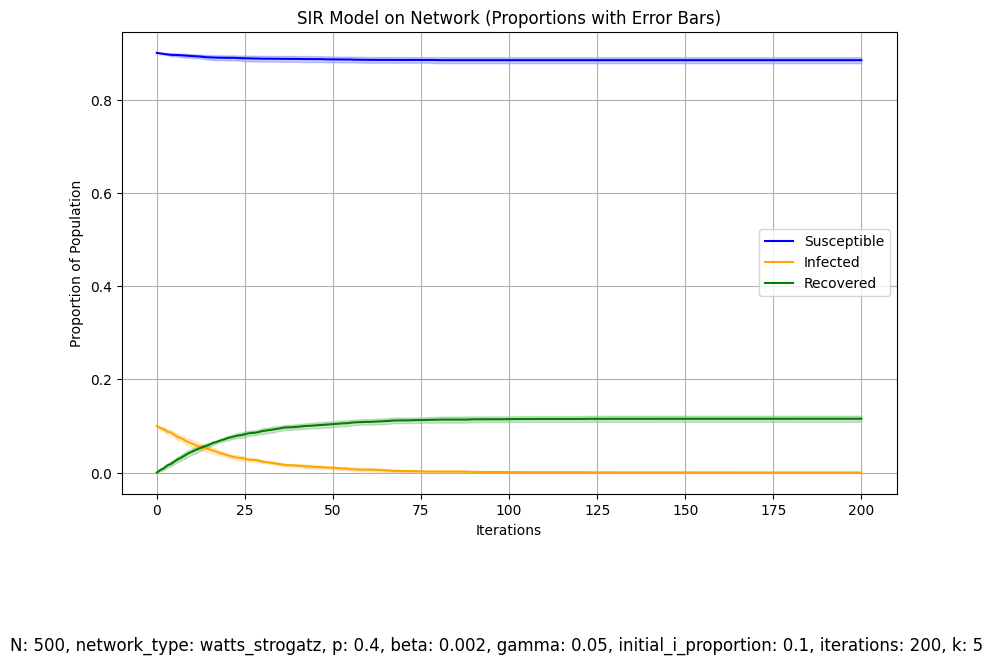

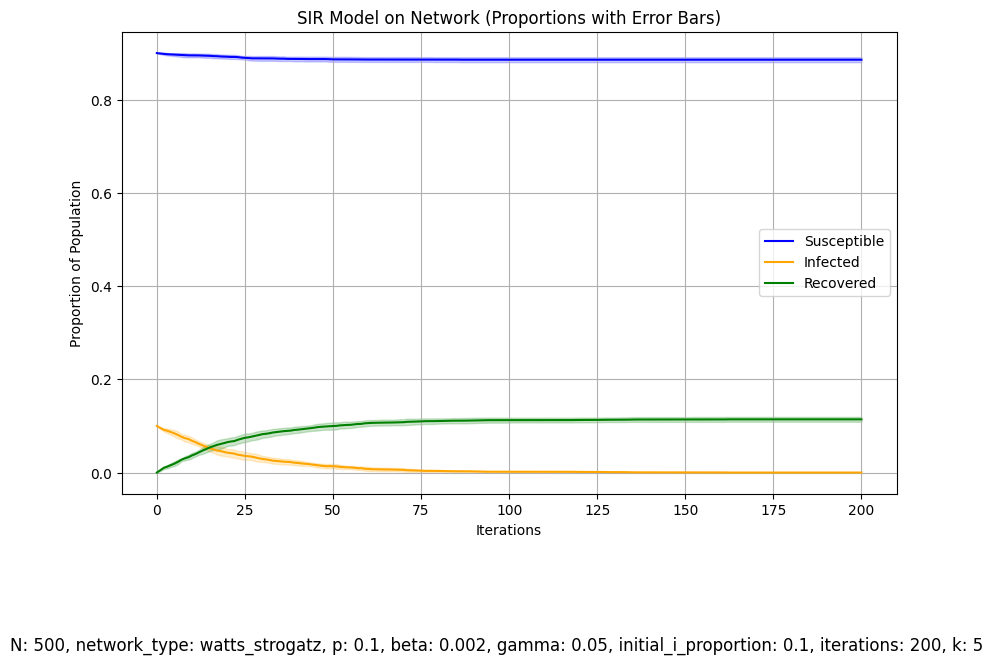

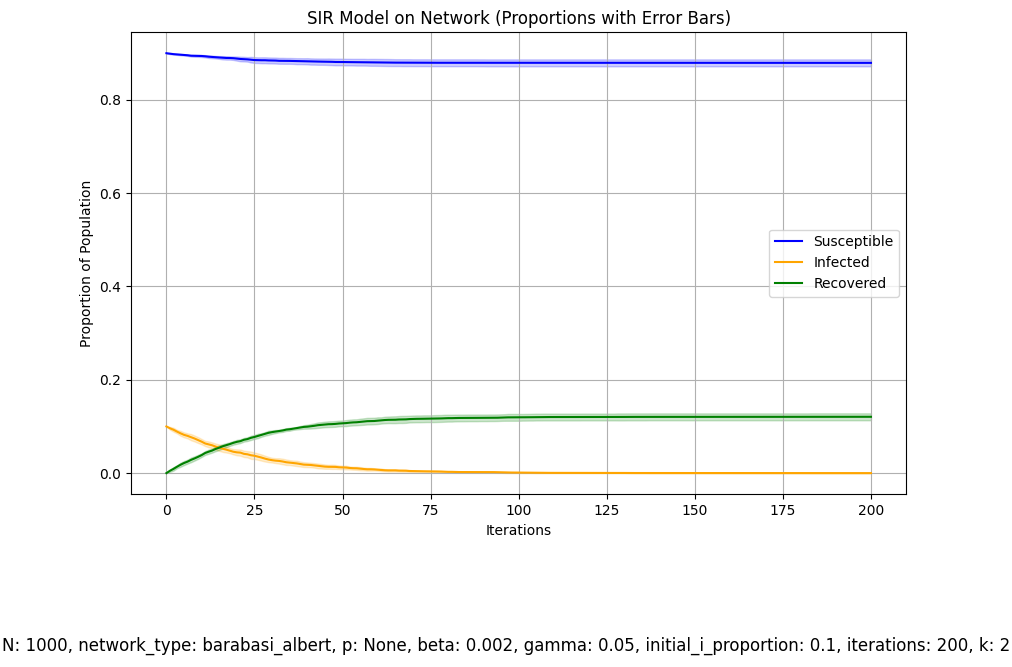

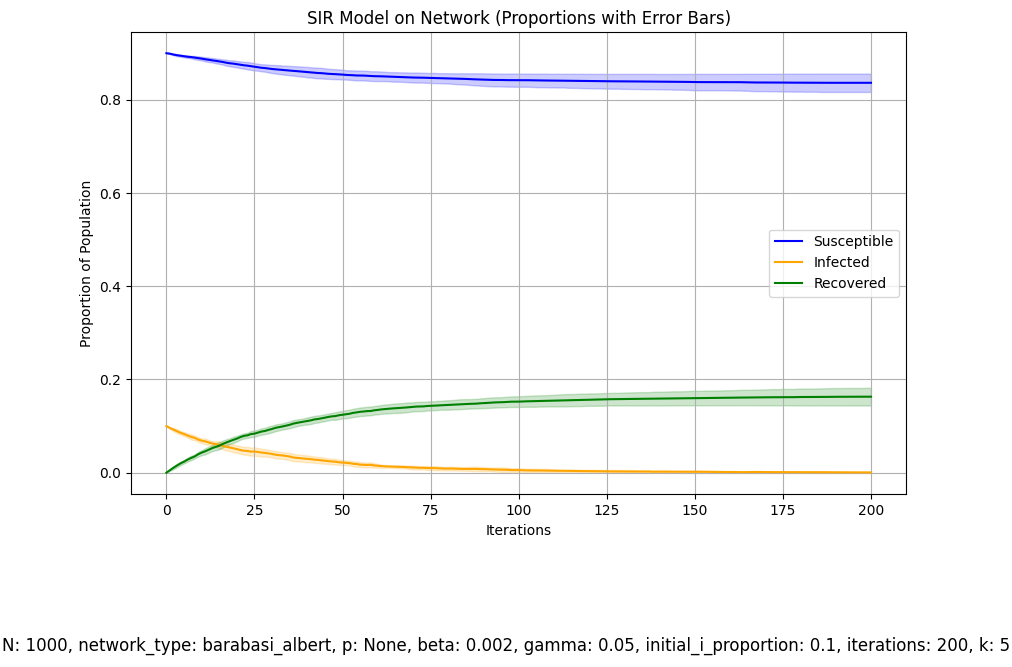

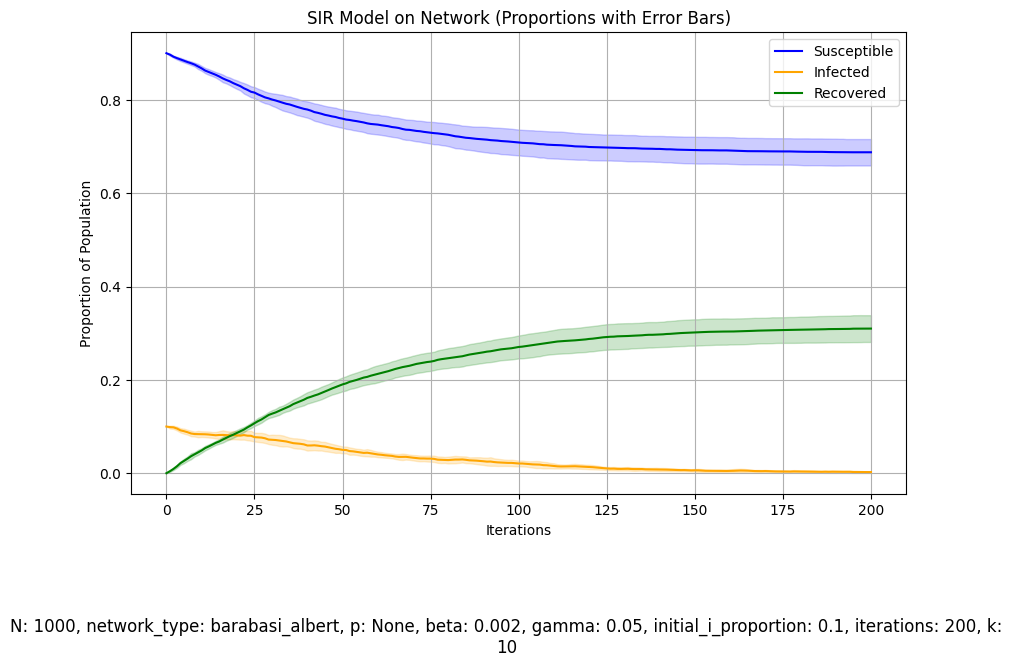

In [16]:
# Call the function for each parameter set and store the results
results_set_random_density = multi_simulate_sir_on_network(**param_set_random_density, plot=True, runs=10)
results_set_small_world_clustering = multi_simulate_sir_on_network(**param_set_small_world_clustering, plot=True, runs=10)
results_set_scale_free_hub_formation = multi_simulate_sir_on_network(**param_set_scale_free_hub_formation, plot=True, runs=10)


In [17]:
result_sets = [results_set_random_density, results_set_small_world_clustering, results_set_scale_free_hub_formation]

In [18]:
def extended_combined_network_statistics(graph, plot=False, caption=None):
    """
    Compute basic statistics, centrality measures (including min and max values), and optional visualizations 
    for a given network/graph, with checks for connectivity.
    
    Parameters:
    - graph (networkx.Graph): The input graph/network for which statistics and visualizations are to be computed.
    - plot (bool): Whether to plot the histograms for node degrees and centrality measures. Default is False.
    - caption (str): Caption to display below the plots if plot=True. Default is None.
    
    Returns:
    - stats_df (pandas.DataFrame): A DataFrame containing the computed statistics of the graph.
    - degree_dist_df (pandas.DataFrame): A DataFrame containing the degree distribution of the nodes in the graph.
    """
    
    # Basic statistics
    stats = {
        "Average Degree": sum(dict(graph.degree()).values()) / len(graph),
        "Clustering Coefficient": nx.average_clustering(graph)
    }
    
    # Check for connectivity
    if nx.is_connected(graph):
        stats["Average Shortest Path Length"] = nx.average_shortest_path_length(graph)
        stats["Max Path Length"] = nx.diameter(graph)
    else:
        stats["Average Shortest Path Length"] = None
        stats["Max Path Length"] = None
    
    # Centrality measures
    degree_centrality = nx.degree_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=500)
    betweenness_centrality = nx.betweenness_centrality(graph)
    
    # Adding average, min, and max values of the centrality measures
    stats["Average Degree Centrality"] = sum(degree_centrality.values()) / len(graph)
    stats["Min Degree Centrality"] = min(degree_centrality.values())
    stats["Max Degree Centrality"] = max(degree_centrality.values())
    
    stats["Average Eigenvector Centrality"] = sum(eigenvector_centrality.values()) / len(graph)
    stats["Min Eigenvector Centrality"] = min(eigenvector_centrality.values())
    stats["Max Eigenvector Centrality"] = max(eigenvector_centrality.values())
    
    stats["Average Betweenness Centrality"] = sum(betweenness_centrality.values()) / len(graph)
    stats["Min Betweenness Centrality"] = min(betweenness_centrality.values())
    stats["Max Betweenness Centrality"] = max(betweenness_centrality.values())
    
    # Degree Distribution
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    
    # Plotting histograms
    if plot:
        plt.figure(figsize=(20, 5))
        
        # Degree Distribution
        plt.subplot(1, 4, 1)
        plt.hist(degree_sequence, bins=50, color='orange')
        plt.title("Degree Distribution")
        plt.xlabel("Degree")
        plt.ylabel("Number of Nodes")
        
        # Degree Centrality
        plt.subplot(1, 4, 2)
        plt.hist(list(degree_centrality.values()), bins=50, color='skyblue')
        plt.title("Degree Centrality")
        plt.xlabel("Degree Centrality")
        plt.ylabel("Number of Nodes")
    
        # Eigenvector Centrality
        plt.subplot(1, 4, 3)
        plt.hist(list(eigenvector_centrality.values()), bins=50, color='salmon')
        plt.title("Eigenvector Centrality")
        plt.xlabel("Eigenvector Centrality")
        plt.ylabel("Number of Nodes")
    
        # Betweenness Centrality
        plt.subplot(1, 4, 4)
        plt.hist(list(betweenness_centrality.values()), bins=50, color='lightgreen')
        plt.title("Betweenness Centrality")
        plt.xlabel("Betweenness Centrality")
        plt.ylabel("Number of Nodes")
        
        # Display caption below the plots if provided
        if caption:
            plt.figtext(0.5, -0.05, caption, ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
        
        plt.tight_layout()
        plt.show()
    
    stats_df = pd.DataFrame([stats])
    degree_dist_df = pd.DataFrame({"Degree": degree_sequence})
    
    return stats_df, degree_dist_df

In [19]:
# 
def aggregate_histogram_data(metric_data, bins=50):
    """
    Adjusted function to aggregate histogram data for a given metric across multiple graphs.
    This function computes histogram bins more adaptively based on the data.
    
    Parameters:
    - metric_data (list): List of metric values for each graph.
    - bins (int): Number of bins for the histogram.
    
    Returns:
    - avg_hist (np.array): Average histogram values.
    - std_hist (np.array): Standard deviation of histogram values.
    """
    all_hist_data = []
    
    # Combine data from all graphs to compute consistent bins
    combined_data = [item for sublist in metric_data for item in sublist]
    _, bin_edges = np.histogram(combined_data, bins=bins)
    
    for data in metric_data:
        hist_data, _ = np.histogram(data, bins=bin_edges, density=False)
        all_hist_data.append(hist_data)
    
    avg_hist = np.mean(all_hist_data, axis=0)
    std_hist = np.std(all_hist_data, axis=0)
    
    return avg_hist, std_hist

In [20]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def extended_combined_network_statistics(graphs: list, plot: bool = False, savefig: bool = True, 
                                         save_stat_table: bool = True, plot_index: int = None, caption = None) -> pd.DataFrame:
    """
    Compute and return average statistics for a list of network/graphs. Optionally, it can plot distributions
    of various metrics and save the statistics to a CSV file.
    
    Parameters:
    -----------
    graphs : list
        A list of NetworkX graph objects for which the statistics are to be computed.
    plot : bool, optional (default = False)
        Whether to plot the distribution of various metrics for the given graphs.
    savefig : bool, optional (default = True)
        [Currently unused] Intended to determine whether to save the plotted figure or not.
    save_stat_table : bool, optional (default = True)
        Whether to save the computed average statistics to a CSV file.
    plot_index : int, optional (default = None)
        An optional index that can be used to name the CSV & plot files uniquely if saving multiple statistics.

    Returns:
    --------
    avg_stats_df : pd.DataFrame
        A pandas DataFrame containing the computed average statistics for the given list of graphs.

    Notes:
    ------
    The function computes various metrics including average degree, clustering coefficient, 
    degree centrality, eigenvector centrality, and betweenness centrality. If the graph is connected,
    it also computes the average shortest path length and the diameter of the graph.
    """

    # Adjust plot_index for naming convention
    # plot_index + 1 so that the first plot is 1 instead of 0
    plot_index = plot_index + 1 if plot_index is not None else ""

    # List to store individual statistics for each graph
    all_stats = []

    # Compute statistics for each graph
    for graph in graphs:
        num_nodes = len(graph)
        stats = {
            "Average Degree": sum(dict(graph.degree()).values()) / num_nodes,
            "Clustering Coefficient": nx.average_clustering(graph),
            "Degree Centrality": sum(nx.degree_centrality(graph).values()) / num_nodes,
            "Eigenvector Centrality": sum(nx.eigenvector_centrality(graph, max_iter=500).values()) / num_nodes,
            "Betweenness Centrality": sum(nx.betweenness_centrality(graph).values()) / num_nodes
        }
        if nx.is_connected(graph):
            stats["Shortest Path Length"] = nx.average_shortest_path_length(graph)
            stats["Path Length"] = nx.diameter(graph)
        else:
            stats["Shortest Path Length"] = np.nan
            stats["Path Length"] = np.nan
        all_stats.append(stats)

    # Compute the average statistics and standard deviations for all graphs
    avg_stats = {key: f"{np.nanmean([d[key] for d in all_stats]):.4f} +- {np.nanstd([d[key] for d in all_stats]):.4f}" for key in all_stats[0]}
    
    # Rename keys to include "Average"
    avg_stats = {"Average " + key: value for key, value in avg_stats.items()}
    
    avg_stats_df = pd.DataFrame([avg_stats])

    # Plot distributions if plot is True
    if plot:
        fig, axs = plt.subplots(1, 4, figsize=(20, 6))

        # Prepare data for metrics including Degree Distribution
        metrics_data = [
            [sorted([d for n, d in graph.degree()], reverse=True) for graph in graphs],
            [list(nx.degree_centrality(graph).values()) for graph in graphs],
            [list(nx.eigenvector_centrality(graph, max_iter=500).values()) for graph in graphs],
            [list(nx.betweenness_centrality(graph).values()) for graph in graphs]
        ]
        titles = ["Degree Distribution", "Degree Centrality Distribution", "Eigenvector Centrality Distribution", "Betweenness Centrality Distribution"]
        colors = ['orange', 'skyblue', 'salmon', 'lightgreen']

        # Plot each metric's distribution
        for i, metric_data in enumerate(metrics_data):
            ax = axs[i]
            bin_edges = np.linspace(min([min(d) for d in metric_data]), max([max(d) for d in metric_data]), 51)

            bin_heights = []
            for data in metric_data:
                label_text = "Individual Graphs" if not bin_heights else ""
                values, _, _ = ax.hist(data, bins=bin_edges, color=colors[i], alpha=0.6, density=True, histtype='step', label=label_text)
                bin_heights.append(values)

            mean_bin_heights = np.mean(bin_heights, axis=0)
            ax.hist(bin_edges[:-1], bins=bin_edges, weights=mean_bin_heights, color='black', histtype='step', label='Mean of Graphs')
            ax.set_title(titles[i])
            ax.set_xlabel(titles[i].replace(" Distribution", ""))
            ax.set_ylabel("Density")
            ax.legend()

        if caption:
            fig.text(0.5, -0.05, caption, ha='center', va='center', fontsize=12)

        plt.tight_layout()


    # Save figure if savefig is True
        if savefig:
            fig_filename = f"2.2. Network Statistics Plot {plot_index}.png"
            plt.savefig(fig_filename)
        plt.show()

    # Save the statistics dataframe if save_stat_table is True
    if save_stat_table:
        table_filename = f"2.2. Network Statistics Table {plot_index}.csv"
        avg_stats_df.to_csv(table_filename, index=False)
    
    return avg_stats_df

# Return the modified function
extended_combined_network_statistics


<function __main__.extended_combined_network_statistics(graphs: list, plot: bool = False, savefig: bool = True, save_stat_table: bool = True, plot_index: int = None, caption=None) -> pandas.core.frame.DataFrame>

In [21]:
result_sets

[[{'parameters': {'N': 500,
    'network_type': 'erdos_renyi',
    'p': 0.05,
    'beta': 0.002,
    'gamma': 0.05,
    'initial_i_proportion': 0.1,
    'iterations': 200,
    'k': 24.950000000000003},
   'avg_trends': [{'S': 0.9000000000000001,
     'I': 0.09999999999999999,
     'R': 0.0},
    {'S': 0.8950000000000001, 'I': 0.09899999999999999, 'R': 0.006},
    {'S': 0.8912000000000001, 'I': 0.097, 'R': 0.0118},
    {'S': 0.8880000000000001, 'I': 0.0948, 'R': 0.0172},
    {'S': 0.8838000000000001, 'I': 0.09459999999999999, 'R': 0.0216},
    {'S': 0.8808, 'I': 0.0924, 'R': 0.026799999999999997},
    {'S': 0.877, 'I': 0.0924, 'R': 0.0306},
    {'S': 0.8736, 'I': 0.09, 'R': 0.036399999999999995},
    {'S': 0.8700000000000001, 'I': 0.09, 'R': 0.039999999999999994},
    {'S': 0.8661999999999999, 'I': 0.08879999999999999, 'R': 0.045},
    {'S': 0.8630000000000001, 'I': 0.08659999999999998, 'R': 0.0504},
    {'S': 0.8610000000000001,
     'I': 0.08099999999999999,
     'R': 0.05800000000000

24.950000000000003
dict_keys(['parameters', 'avg_trends', 'std_S', 'std_I', 'std_R', 'networks'])
Network Parameters (10 networks generated with these parameters))


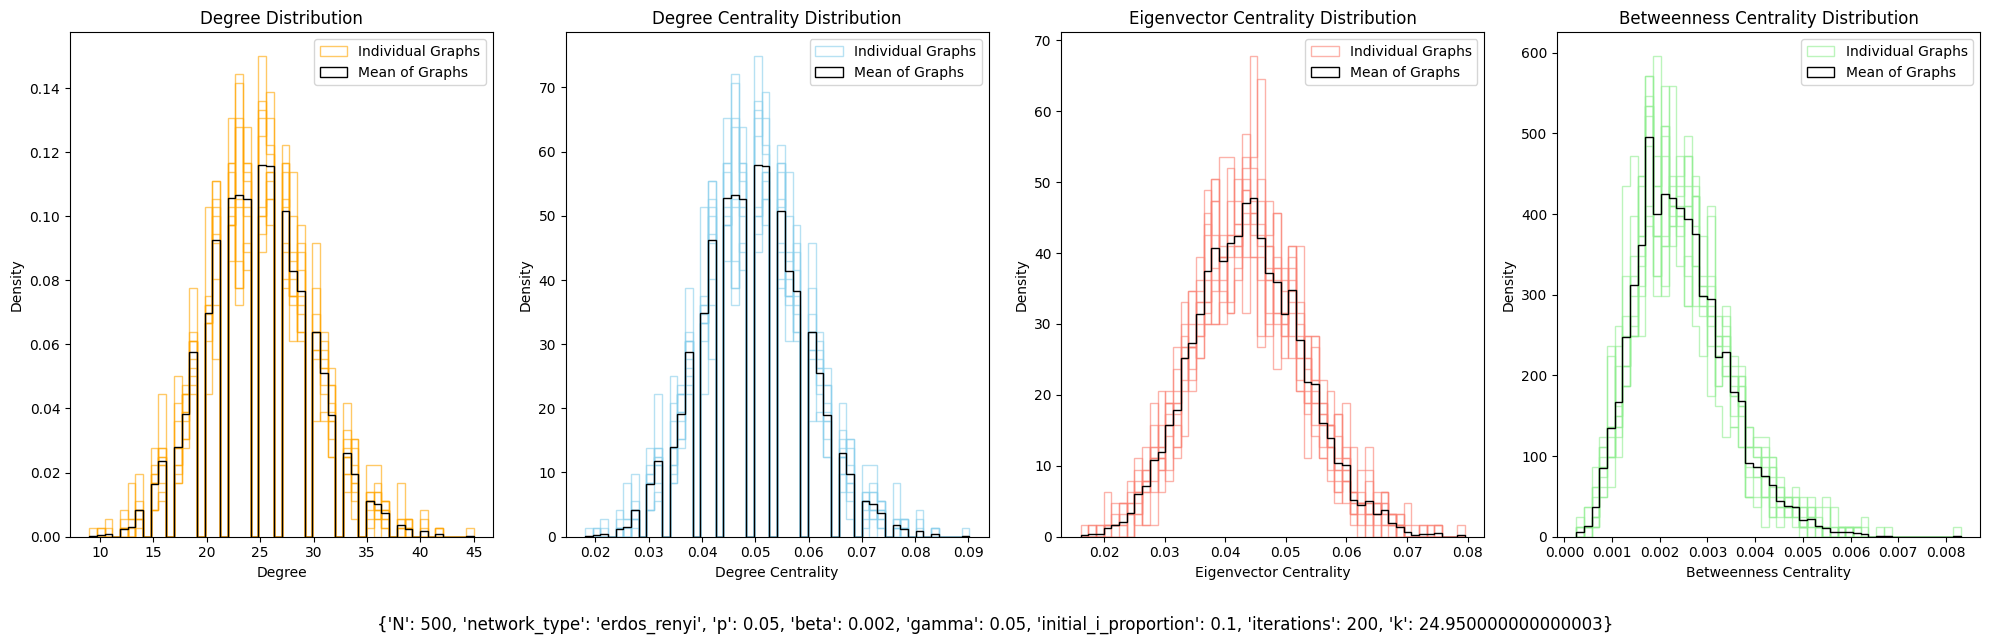

,Average Average Degree,Average Clustering Coefficient,Average Degree Centrality,Average Eigenvector Centrality,Average Betweenness Centrality,Average Shortest Path Length,Average Path Length
0,24.8828 +- 0.2076,0.0500 +- 0.0011,0.0499 +- 0.0004,0.0438 +- 0.0001,0.0025 +- 0.0000,2.2241 +- 0.0063,3.1000 +- 0.3000


99.80000000000001
dict_keys(['parameters', 'avg_trends', 'std_S', 'std_I', 'std_R', 'networks'])
Network Parameters (10 networks generated with these parameters))


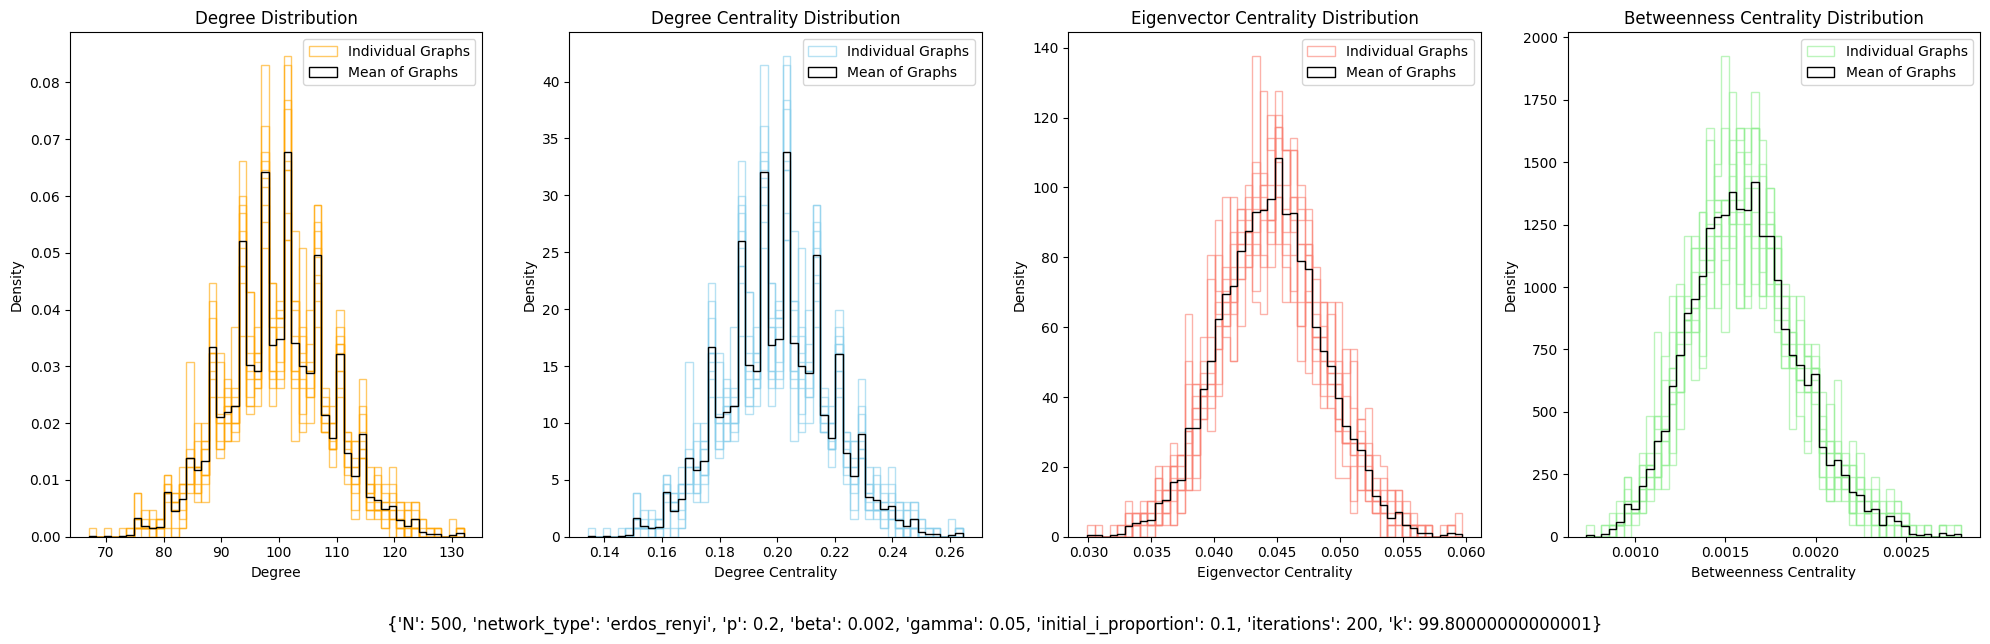

,Average Average Degree,Average Clustering Coefficient,Average Degree Centrality,Average Eigenvector Centrality,Average Betweenness Centrality,Average Shortest Path Length,Average Path Length
0,99.7496 +- 0.6189,0.2001 +- 0.0012,0.1999 +- 0.0012,0.0445 +- 0.0000,0.0016 +- 0.0000,1.8001 +- 0.0012,2.0000 +- 0.0000


249.5
dict_keys(['parameters', 'avg_trends', 'std_S', 'std_I', 'std_R', 'networks'])
Network Parameters (10 networks generated with these parameters))


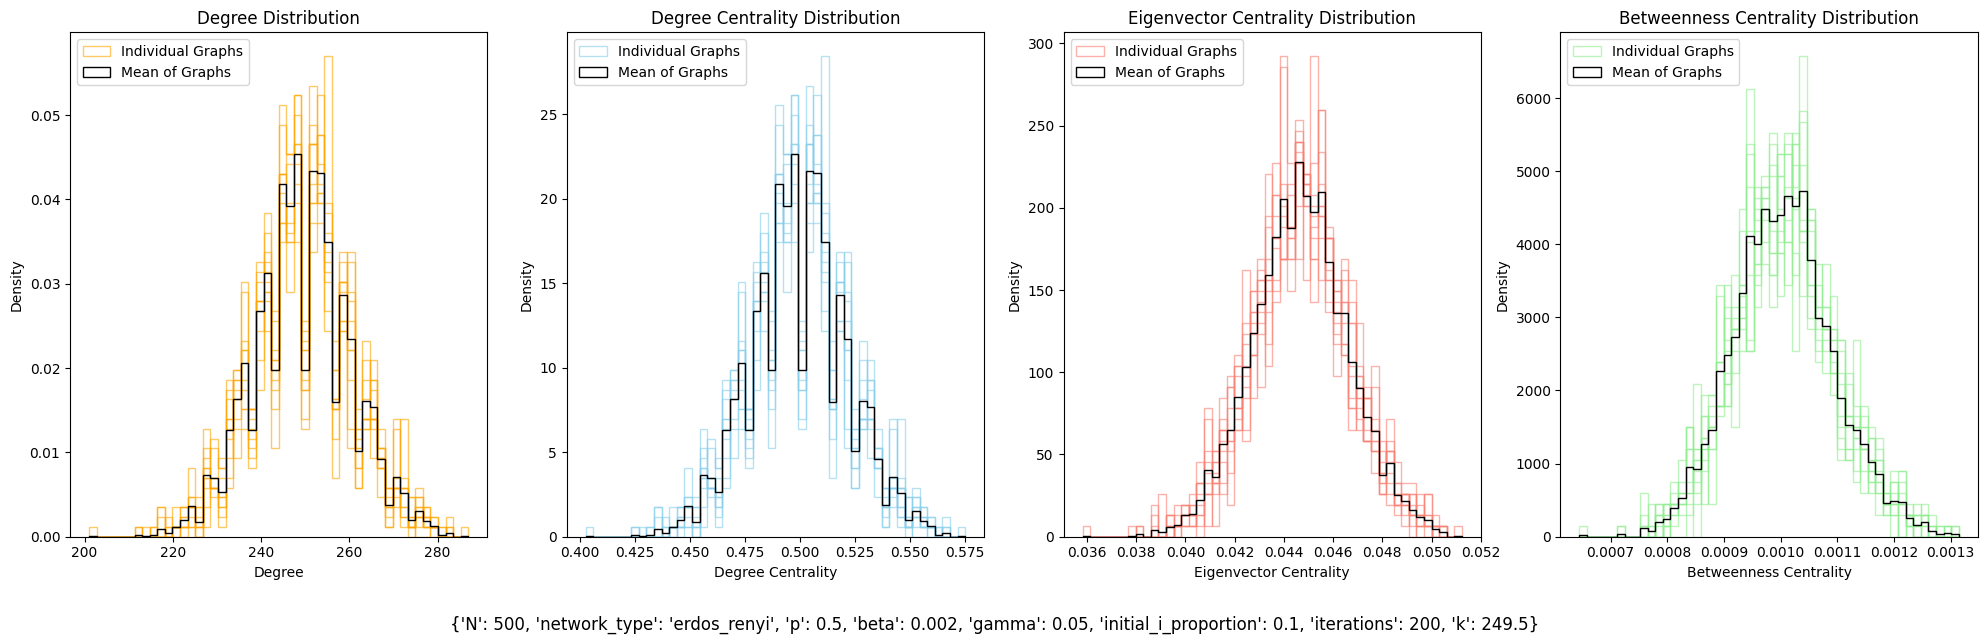

,Average Average Degree,Average Clustering Coefficient,Average Degree Centrality,Average Eigenvector Centrality,Average Betweenness Centrality,Average Shortest Path Length,Average Path Length
0,249.2896 +- 0.7670,0.4995 +- 0.0016,0.4996 +- 0.0015,0.0447 +- 0.0000,0.0010 +- 0.0000,1.5004 +- 0.0015,2.0000 +- 0.0000


5
dict_keys(['parameters', 'avg_trends', 'std_S', 'std_I', 'std_R', 'networks'])
Network Parameters (10 networks generated with these parameters))


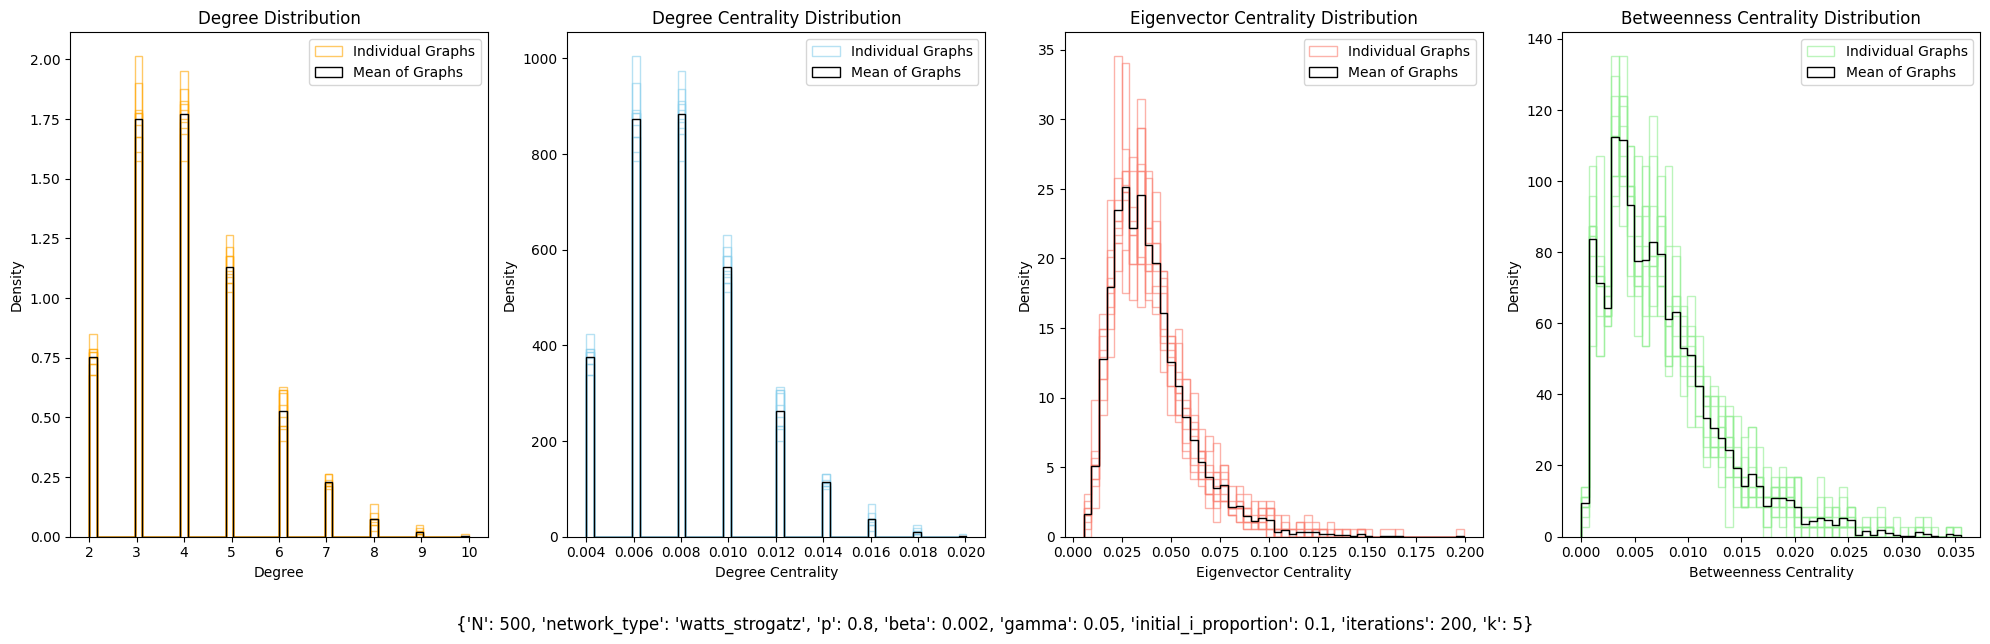

,Average Average Degree,Average Clustering Coefficient,Average Degree Centrality,Average Eigenvector Centrality,Average Betweenness Centrality,Average Shortest Path Length,Average Path Length
0,4.0000 +- 0.0000,0.0101 +- 0.0043,0.0080 +- 0.0000,0.0398 +- 0.0006,0.0076 +- 0.0000,4.7789 +- 0.0166,8.1000 +- 0.3000


5
dict_keys(['parameters', 'avg_trends', 'std_S', 'std_I', 'std_R', 'networks'])
Network Parameters (10 networks generated with these parameters))


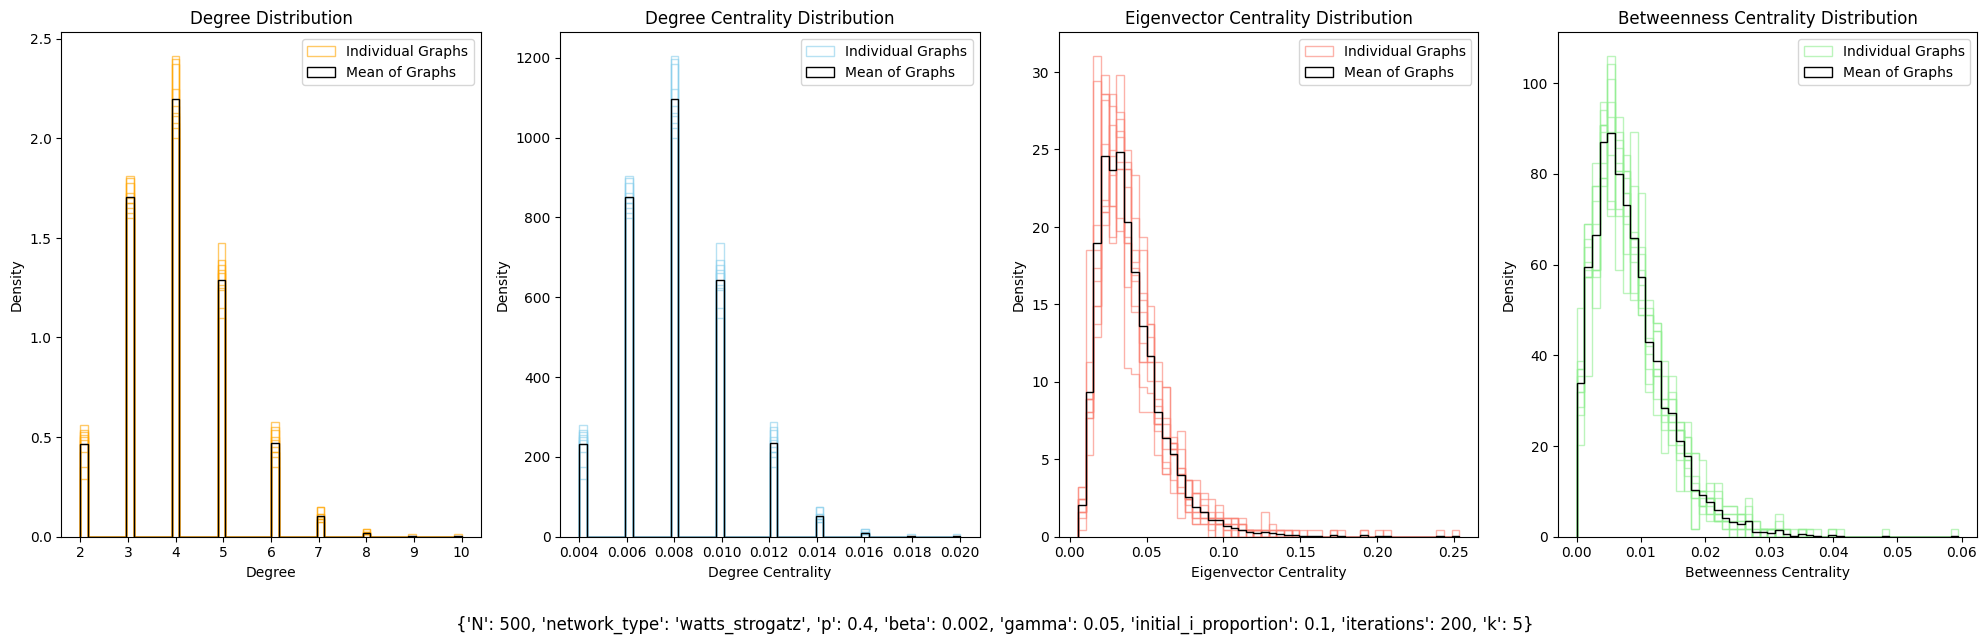

,Average Average Degree,Average Clustering Coefficient,Average Degree Centrality,Average Eigenvector Centrality,Average Betweenness Centrality,Average Shortest Path Length,Average Path Length
0,4.0000 +- 0.0000,0.1129 +- 0.0088,0.0080 +- 0.0000,0.0392 +- 0.0014,0.0084 +- 0.0001,5.1651 +- 0.0427,9.4000 +- 0.4899


5
dict_keys(['parameters', 'avg_trends', 'std_S', 'std_I', 'std_R', 'networks'])
Network Parameters (10 networks generated with these parameters))


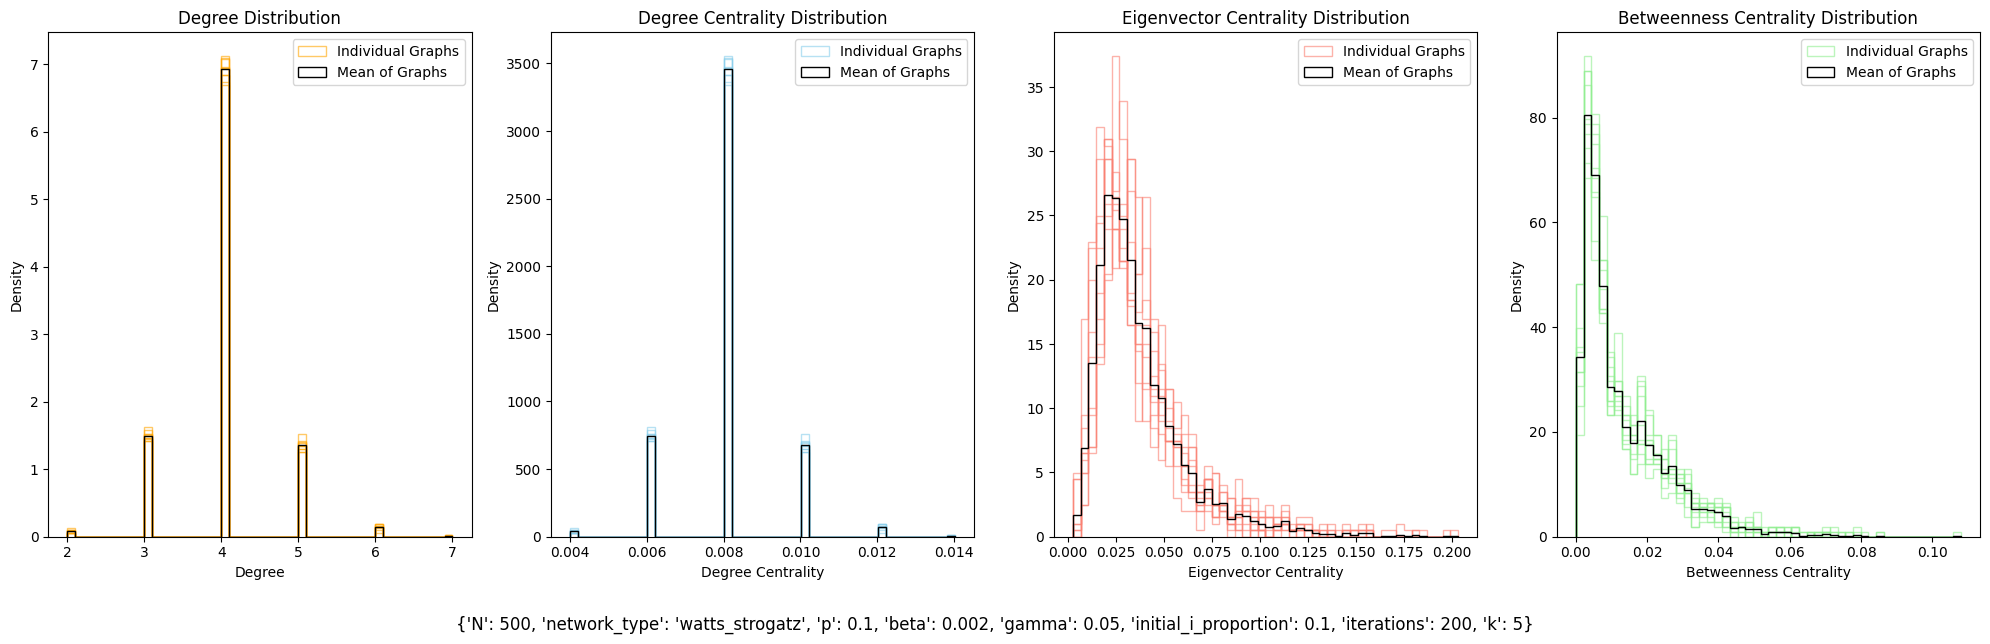

,Average Average Degree,Average Clustering Coefficient,Average Degree Centrality,Average Eigenvector Centrality,Average Betweenness Centrality,Average Shortest Path Length,Average Path Length
0,4.0000 +- 0.0000,0.3733 +- 0.0076,0.0080 +- 0.0000,0.0377 +- 0.0014,0.0134 +- 0.0004,7.6494 +- 0.1861,15.2000 +- 1.4000


2
dict_keys(['parameters', 'avg_trends', 'std_S', 'std_I', 'std_R', 'networks'])
Network Parameters (10 networks generated with these parameters))


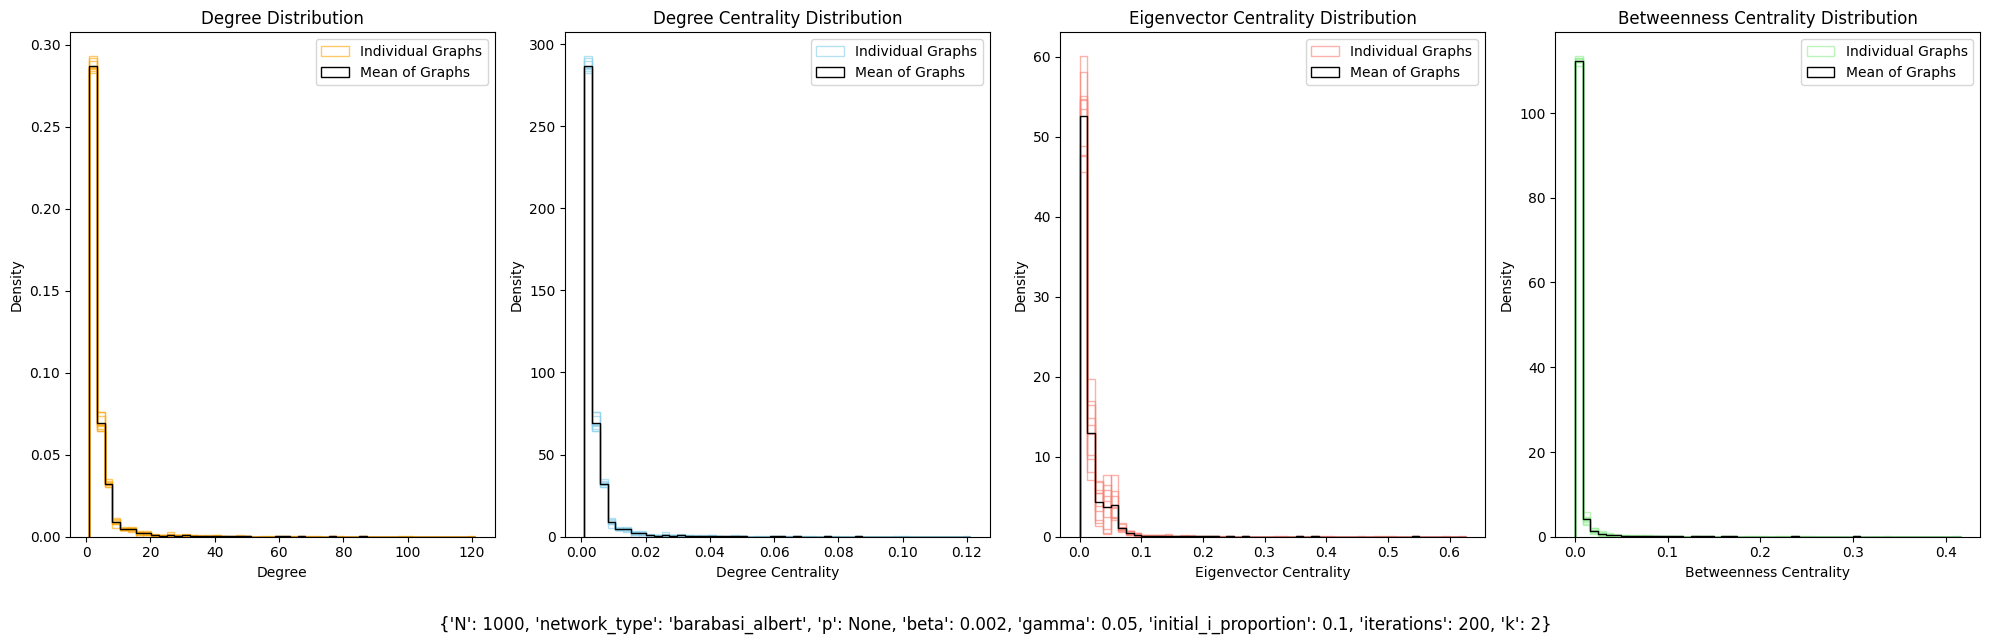

,Average Average Degree,Average Clustering Coefficient,Average Degree Centrality,Average Eigenvector Centrality,Average Betweenness Centrality,Average Shortest Path Length,Average Path Length
0,3.9920 +- 0.0000,0.0260 +- 0.0030,0.0040 +- 0.0000,0.0163 +- 0.0010,0.0031 +- 0.0000,4.0936 +- 0.0409,7.2000 +- 0.4000


5
dict_keys(['parameters', 'avg_trends', 'std_S', 'std_I', 'std_R', 'networks'])
Network Parameters (10 networks generated with these parameters))


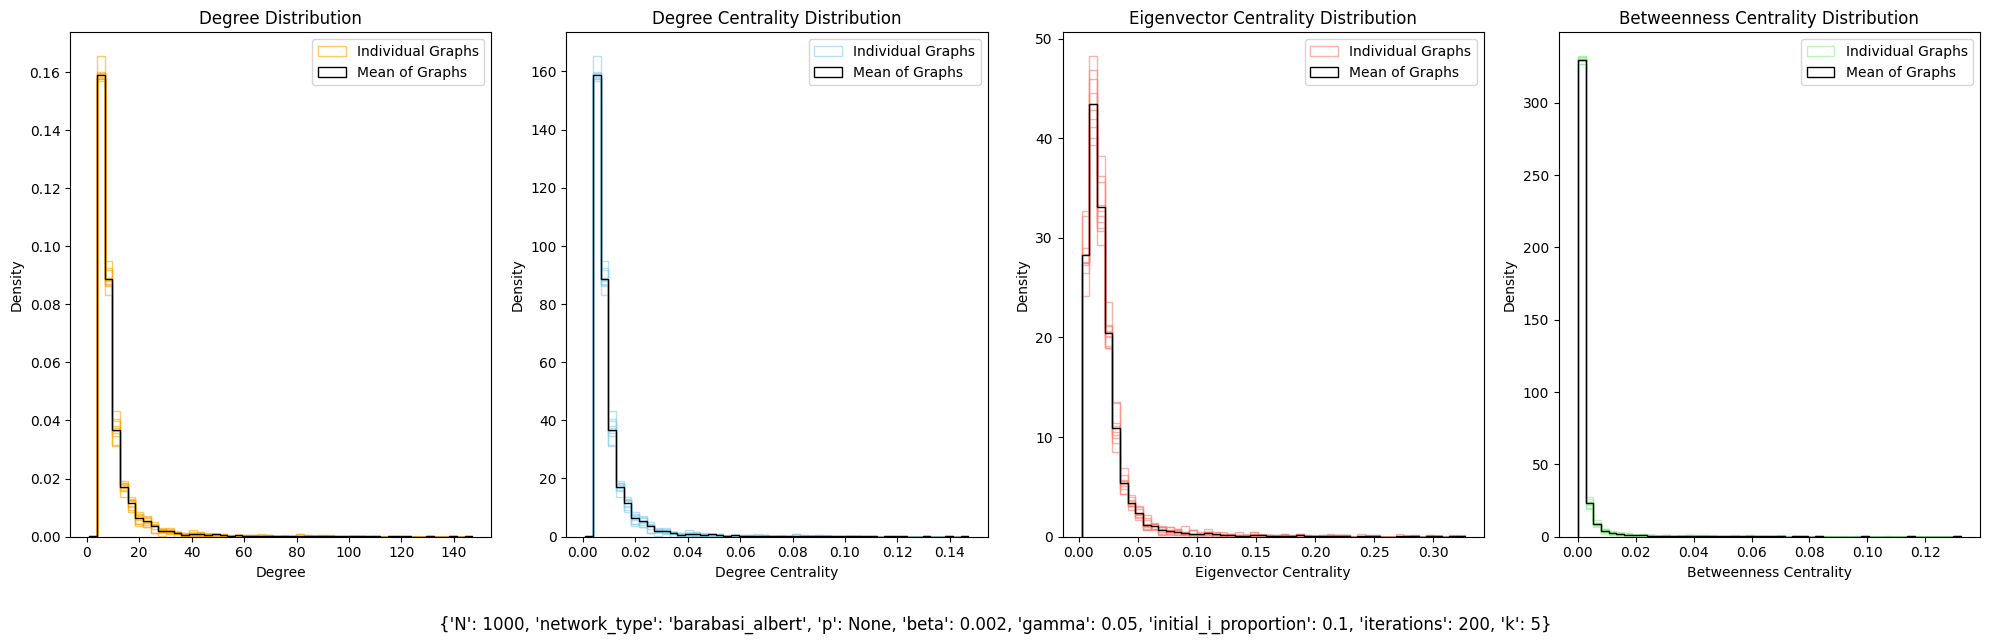

,Average Average Degree,Average Clustering Coefficient,Average Degree Centrality,Average Eigenvector Centrality,Average Betweenness Centrality,Average Shortest Path Length,Average Path Length
0,9.9500 +- 0.0000,0.0404 +- 0.0028,0.0100 +- 0.0000,0.0217 +- 0.0002,0.0020 +- 0.0000,2.9759 +- 0.0126,5.0000 +- 0.0000


10
dict_keys(['parameters', 'avg_trends', 'std_S', 'std_I', 'std_R', 'networks'])
Network Parameters (10 networks generated with these parameters))


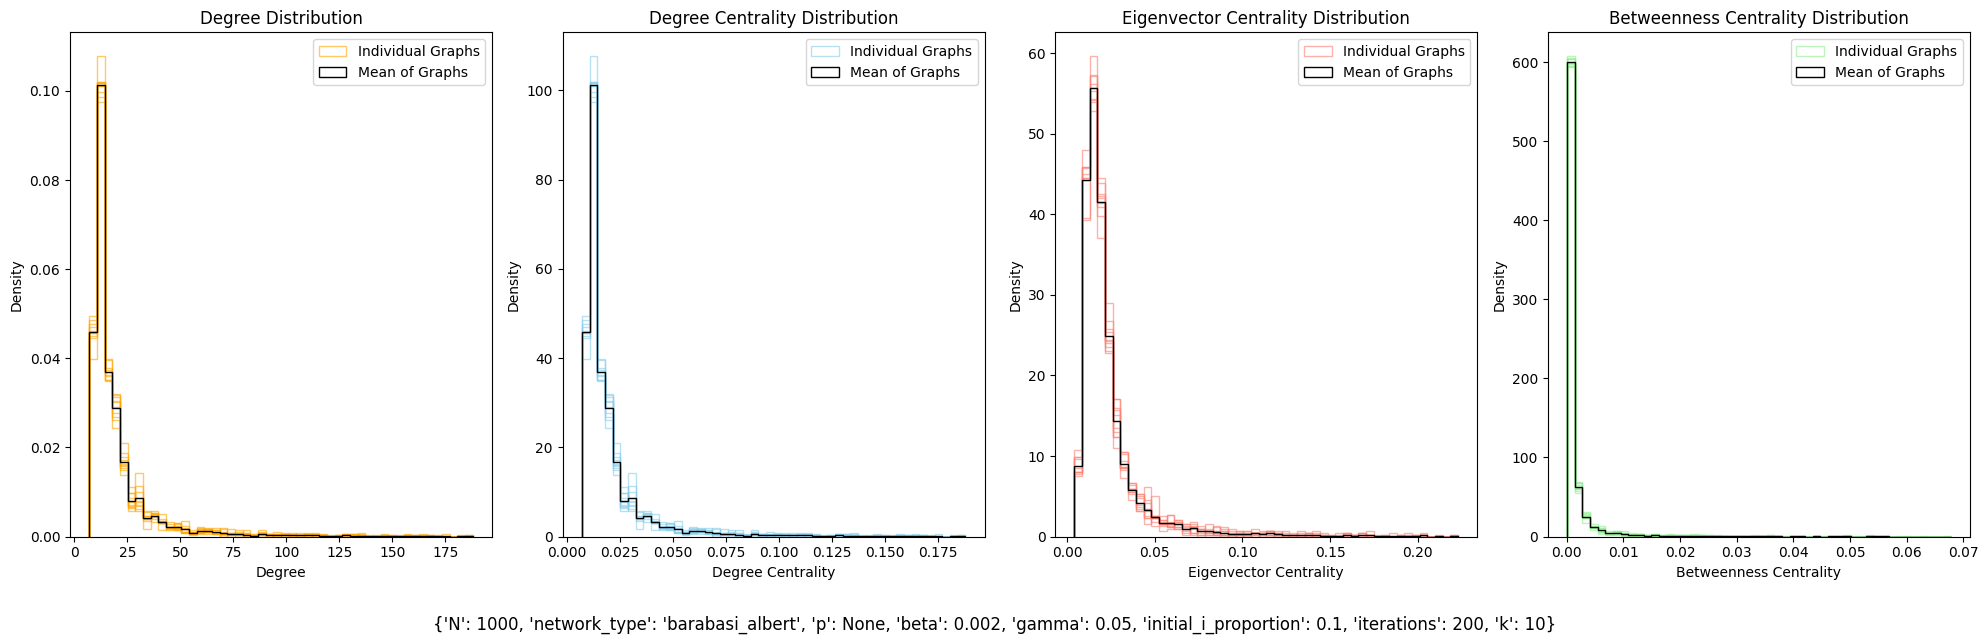

,Average Average Degree,Average Clustering Coefficient,Average Degree Centrality,Average Eigenvector Centrality,Average Betweenness Centrality,Average Shortest Path Length,Average Path Length
0,19.8000 +- 0.0000,0.0607 +- 0.0022,0.0198 +- 0.0000,0.0236 +- 0.0001,0.0016 +- 0.0000,2.5571 +- 0.0052,4.0000 +- 0.0000


In [22]:
plot_index = 0
for result_set in result_sets:
    for result in result_set:
        
        result_now = result.copy()
        print(result_now['parameters'].get('k'))
        print(result_now.keys())
        print('Network Parameters (10 networks generated with these parameters))')
        caption = result['parameters']
        data = extended_combined_network_statistics(result['networks'], plot=True, plot_index=plot_index, savefig=True, save_stat_table=True, caption=caption)
        plot_index += 1
        display(data)


# 2.4 Real Contact network

## Importing

In [23]:
df_contact_network = pd.read_csv('transmission_network.csv', delimiter=';')
index = df_contact_network['Unnamed: 0']
# df_contact_network = df_contact_network.set_index(index)
df_contact_network.index = index
df_contact_network = df_contact_network.drop(columns=['Unnamed: 0'])


df_contact_network

,1467,1591,1513,1568,1562,1524,1771,1428,1600,1523,1525,1529,1544,1519,1583,1510,1549,1553,1606,1622,1599,1560,1602,1631,1573,1537,1531,1539,1604,1543,1526,1582,1551,1269,1463,1628,1552,1514,1547,1504,1601,1629,1616,1518,1691,1545,1580,1569,1520,1742,1430,1453,1563,1434,1448,1487,1626,1512,1527,1592,1437,1542,1461,1578,1521,1593,1598,1655,1436,1724,1469,1489,1853,1915,1451,1459,1441,1789,1920,1538,1874,1574,1532,1617,1779,1522,1774,1825,1903,1791,1857,1678,1449,1716,1808,1503,1839,1641,1773,1458,1546,1468,1558,1871,1572,1767,1872,1879,1613,1444,1554,1623,1452,1858,1634,1497,1500,1511,1556,1590,1530,1559,1596,1464,1619,1904,1517,1557,1460,1499,1541,1555,1533,1840,1612,1465,1579,1426,1470,1466,1608,1528,1650,1457,1668,1762,1743,1501,1587,1535,1431,1438,1516,1847,1507,1425,1433,1652,1900,1747,1917,1548,1495,1493,1790,1912,1731,1888,1916,1828,1805,1863,1597,1848,1919,1581,1435,1498,1603,1842,1770,1427,1496,1505,1761,1740,1676,1443,1659,1700,1757,1688,1696,1831,1564,1455,1550,1630,1442,1706,1609,1471,1766,1648,1783,1756,1640,1752,1749,1585,1645,1707,1764,1644,1834,1772,1698,1712,1661,1657,1710,1681,1811,1638,1769,1674,1577,1614,1667,1735,1649,1821,1664,1713,1647,1666,1701,1677,1595,1654,1665,1566,1642,1675,1651,1685,1727,1845,1643,1689,1576,1911,1866,1671,1439,1899,1673,1680,1732,1765,1905,1813,1683,1704,1754,1669,1605,1575,1679,1806,1699,1759,1695,1692,1660,1819,1694,1684,1703,1440,1787,1851,1656,1687,1635,1702,1625,1711,1670,1477,1672,1728,1462,1922,1803,1902,1826,1921,1480,1894,1836,1854,1906,1725,1476,1502,1884,1798,1862,1485,1893,1898,1892,1890,1885,1792,1924,1478,1918,1475,1484,1786,1850,1914,1901,1880,1841,1794,1897,1855,1491,1877,1923,1482,1490,1775,1835,1570,1887,1479,1886,1875,1717,1889,1868,1908,1873,1483,1718,1865,1492,1829,1473,1802,1734,1907,1721,1816,1882,1796,1881,1807,1818,1755,1768,1715,1663,1708,1658,1876,1913,1883,1870,1446
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1467,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1591,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,12,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1513,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [24]:
# remove the weights, replace all values > 1 with 1
df_contact_network = df_contact_network.applymap(lambda x: 1 if x > 0 else 0)

In [25]:
df_contact_network

,1467,1591,1513,1568,1562,1524,1771,1428,1600,1523,1525,1529,1544,1519,1583,1510,1549,1553,1606,1622,1599,1560,1602,1631,1573,1537,1531,1539,1604,1543,1526,1582,1551,1269,1463,1628,1552,1514,1547,1504,1601,1629,1616,1518,1691,1545,1580,1569,1520,1742,1430,1453,1563,1434,1448,1487,1626,1512,1527,1592,1437,1542,1461,1578,1521,1593,1598,1655,1436,1724,1469,1489,1853,1915,1451,1459,1441,1789,1920,1538,1874,1574,1532,1617,1779,1522,1774,1825,1903,1791,1857,1678,1449,1716,1808,1503,1839,1641,1773,1458,1546,1468,1558,1871,1572,1767,1872,1879,1613,1444,1554,1623,1452,1858,1634,1497,1500,1511,1556,1590,1530,1559,1596,1464,1619,1904,1517,1557,1460,1499,1541,1555,1533,1840,1612,1465,1579,1426,1470,1466,1608,1528,1650,1457,1668,1762,1743,1501,1587,1535,1431,1438,1516,1847,1507,1425,1433,1652,1900,1747,1917,1548,1495,1493,1790,1912,1731,1888,1916,1828,1805,1863,1597,1848,1919,1581,1435,1498,1603,1842,1770,1427,1496,1505,1761,1740,1676,1443,1659,1700,1757,1688,1696,1831,1564,1455,1550,1630,1442,1706,1609,1471,1766,1648,1783,1756,1640,1752,1749,1585,1645,1707,1764,1644,1834,1772,1698,1712,1661,1657,1710,1681,1811,1638,1769,1674,1577,1614,1667,1735,1649,1821,1664,1713,1647,1666,1701,1677,1595,1654,1665,1566,1642,1675,1651,1685,1727,1845,1643,1689,1576,1911,1866,1671,1439,1899,1673,1680,1732,1765,1905,1813,1683,1704,1754,1669,1605,1575,1679,1806,1699,1759,1695,1692,1660,1819,1694,1684,1703,1440,1787,1851,1656,1687,1635,1702,1625,1711,1670,1477,1672,1728,1462,1922,1803,1902,1826,1921,1480,1894,1836,1854,1906,1725,1476,1502,1884,1798,1862,1485,1893,1898,1892,1890,1885,1792,1924,1478,1918,1475,1484,1786,1850,1914,1901,1880,1841,1794,1897,1855,1491,1877,1923,1482,1490,1775,1835,1570,1887,1479,1886,1875,1717,1889,1868,1908,1873,1483,1718,1865,1492,1829,1473,1802,1734,1907,1721,1816,1882,1796,1881,1807,1818,1755,1768,1715,1663,1708,1658,1876,1913,1883,1870,1446
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1467,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1591,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1513,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [26]:
# print(df_contact_network.values.sum())
# Checking if the sum of all values in the DataFrame matches the expected edge count (1265)
# note: directed graph so, sum of all values is 2*edge count
assert df_contact_network.values.sum()/2 == 1265
print('Edge count matches expected value: 1265')


# # Checking if the number of columns (nodes) and rows (nodes) match the expected node count (374)
assert df_contact_network.shape[0] == df_contact_network.shape[1] == 374
print('Node count matches expected value: 374')


Edge count matches expected value: 1265
Node count matches expected value: 374


In [27]:
# Convert to numpy matrix so we can import in network X
adj_matrix_contact_network = df_contact_network.to_numpy()

In [28]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix_contact_network)

# Network statistics

C:\Users\nitai\AppData\Local\Temp\ipykernel_12824\3438625929.py:63: RuntimeWarning: Mean of empty slice
  avg_stats = {key: f"{np.nanmean([d[key] for d in all_stats]):.4f} +- {np.nanstd([d[key] for d in all_stats]):.4f}" for key in all_stats[0]}
C:\Users\nitai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


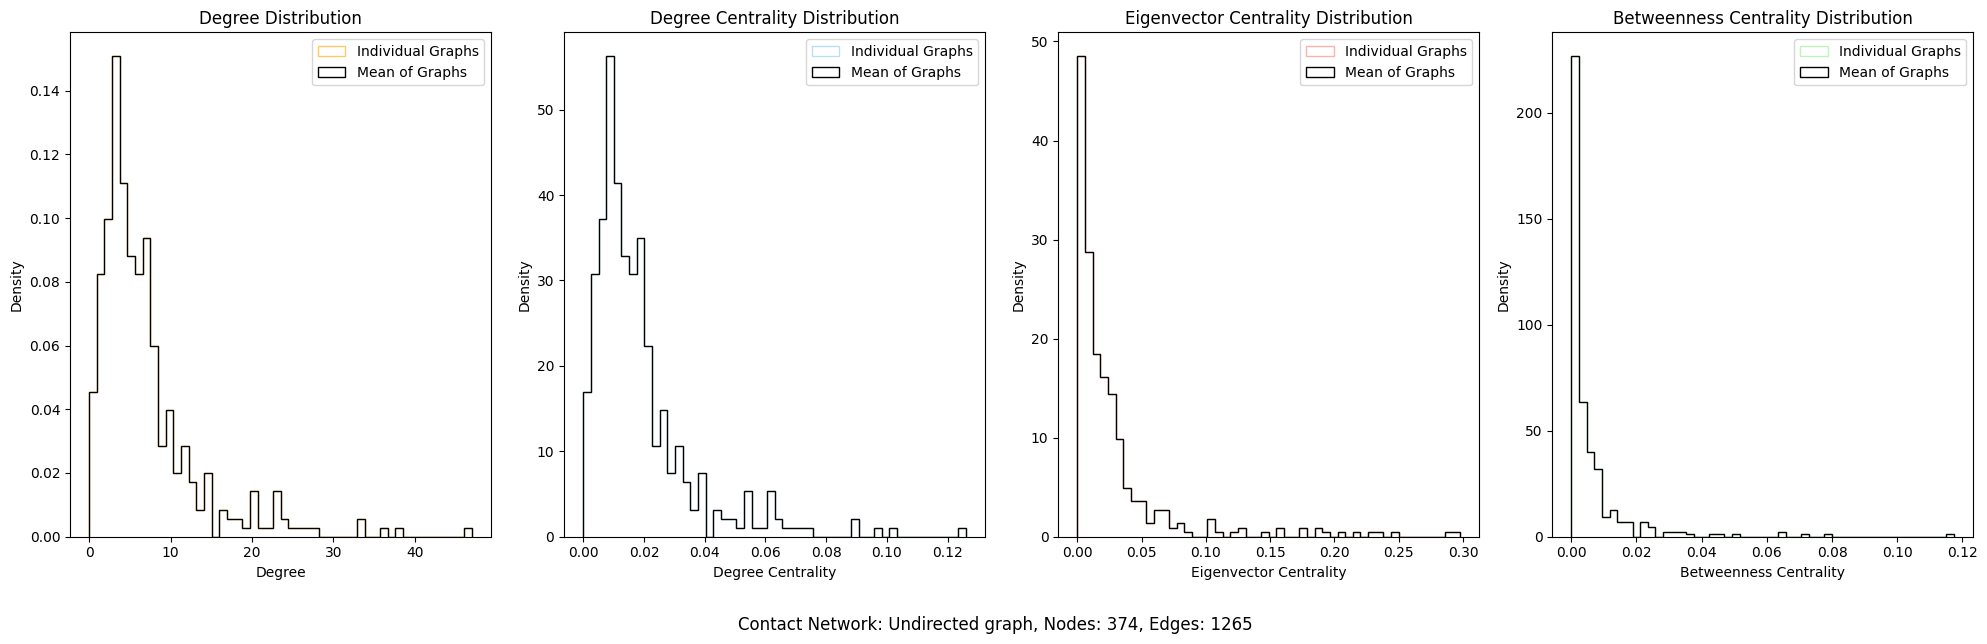

,Average Average Degree,Average Clustering Coefficient,Average Degree Centrality,Average Eigenvector Centrality,Average Betweenness Centrality,Average Shortest Path Length,Average Path Length
0,6.7647 +- 0.0000,0.2960 +- 0.0000,0.0181 +- 0.0000,0.0275 +- 0.0000,0.0057 +- 0.0000,nan +- nan,nan +- nan


In [29]:
# getting network statistics
extended_combined_network_statistics([G], plot=True, plot_index=plot_index, savefig=True, save_stat_table=True, caption='Contact Network: Undirected graph, Nodes: 374, Edges: 1265')

# Vaccination

In [30]:
def vaccinate_nodes(graph, vaccination_strategy, vaccination_budget):
    """Vaccinate nodes based on the chosen strategy."""
    
    if vaccination_strategy == "random":
        susceptible_nodes = [node for node, data in graph.nodes(data=True) if data['state'] == 'S']
        return random.sample(susceptible_nodes, min(vaccination_budget, len(susceptible_nodes)))
    
    elif vaccination_strategy in ["degree", "eigenvector", "betweenness"]:
        if vaccination_strategy == "degree":
            centrality = nx.degree_centrality(graph)
        elif vaccination_strategy == "eigenvector":
            centrality = nx.eigenvector_centrality(graph)
        elif vaccination_strategy == "betweenness":
            centrality = nx.betweenness_centrality(graph)
        
        # Sort nodes by centrality
        sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)
        vaccinated_nodes = []
        for node in sorted_nodes:
            if graph.nodes[node]['state'] == 'S' and len(vaccinated_nodes) < vaccination_budget:
                vaccinated_nodes.append(node)
        return vaccinated_nodes

    else:
        raise ValueError("Unknown vaccination strategy")

In [31]:
def test(graph, node_nr, test_accuracy):
    """
    Determines the state of a node in a graph using a test with a given accuracy.
    
    The function simulates the process of testing a node for an 'Infected' state. If the node 
    is infected and the test (with its given accuracy) detects it, it returns 'I'. If the test fails,
    it returns a random state from the remaining states (either 'S' or 'R'). If the node is not infected, 
    its actual state is returned.
    
    Parameters:
    - Graph : NetworkX Graph (or similar structure)
        The graph representing the disease model. Each node should have an attribute 'state' 
        which indicates its current state ('S', 'I', or 'R').
    
    - node_nr : int
        The identifier for the node in the graph to be tested.
        
    - test_accuracy : float
        The accuracy of the test for detecting the 'I' state. It should be a value between 0 and 1, 
        where 1 means the test is always accurate and 0 means it's never accurate.
        
    Returns:
    - str
        The detected state of the node after the test, which can be 'S', 'I', or 'R'.
    """
    
    states = ['S','I', 'R']
    print(graph.nodes[node_nr])
    found_state = graph.nodes[node_nr]['state']

    # remove found state from the state list
    new_states = states.copy()
    new_states.remove(found_state)

    if found_state == 'I':
        if random.random() < test_accuracy:
            return 'I'
        else:
            return random.choice(new_states)
    else:
        return found_state
    


In [32]:
def simulate_sir_set_graph(graph, beta=0.002, gamma=0.05, initial_i_proportion=0.1, iterations=200, caption=None, num_runs=1, plot=True, plot_error_mode="std",vaccination_strategy=None, vaccination_budget=10, testing_mode=None, test_accuracy=0.8, test_budget=100):
    N = len(graph.nodes())
    all_runs_trends = []
    for run in range(num_runs):
        states = {node: 'S' for node in graph.nodes()}
        initial_infected_nodes = random.sample(list(graph.nodes()), int(N * initial_i_proportion))
        for node in initial_infected_nodes:
            states[node] = 'I'

        for node in graph.nodes():
            graph.nodes[node]['state'] = states[node]
            
        trends = [{'S': (N - len(initial_infected_nodes))/N, 'I': len(initial_infected_nodes)/N, 'R': 0}]
        
        for _ in range(iterations):
            # Vaccinate nodes at the beginning of iteration
            if vaccination_strategy is not None:
                if testing_mode is not None:
                    nodes_to_vaccinate = find_nodes_to_vaccinate(graph, vaccination_strategy, 
                                                                    vaccination_budget=10, 
                                                                    testing_mode=testing_mode, 
                                                                    test_accuracy=test_accuracy, 
                                                                    test_budget=test_budget)
                else:
                    nodes_to_vaccinate = find_nodes_to_vaccinate(graph, vaccination_strategy, 
                                                                    vaccination_budget=10, 
                                                                    testing_mode=None)
                    
                for node in nodes_to_vaccinate:
                    states[node] = 'R'
                    
                # Update graph's node attributes immediately after vaccination
                nx.set_node_attributes(graph, states, 'state')
            
                # Ensure states dictionary reflects the current state of the graph
                states = {node: data['state'] for node, data in graph.nodes(data=True)}
            
            new_states = states.copy()
            for node, state in states.items():
                if state == 'I':
                    if random.random() < gamma:
                        new_states[node] = 'R'
                        continue
                    neighbors = list(graph.neighbors(node))
                    for neighbor in neighbors:
                        if new_states[neighbor] == 'S' and random.random() < beta:
                            new_states[neighbor] = 'I'
            states = new_states
            
            # Update trends after each iteration
            trends.append({'S': list(states.values()).count('S')/N,
                            'I': list(states.values()).count('I')/N,
                            'R': list(states.values()).count('R')/N})
        
        all_runs_trends.append(trends)

    avg_trends = [{'S': sum([trend[i]['S'] for trend in all_runs_trends])/num_runs,
                   'I': sum([trend[i]['I'] for trend in all_runs_trends])/num_runs,
                   'R': sum([trend[i]['R'] for trend in all_runs_trends])/num_runs}
                  for i in range(iterations + 1)]
    
    # Calculate error values based on mode
    if plot_error_mode == "std":
        error_S = [np.std([trend[i]['S'] for trend in all_runs_trends]) for i in range(iterations + 1)]
        error_I = [np.std([trend[i]['I'] for trend in all_runs_trends]) for i in range(iterations + 1)]
        error_R = [np.std([trend[i]['R'] for trend in all_runs_trends]) for i in range(iterations + 1)]
    elif plot_error_mode == "minmax":
        error_S = [(min([trend[i]['S'] for trend in all_runs_trends]), max([trend[i]['S'] for trend in all_runs_trends])) for i in range(iterations + 1)]
        error_I = [(min([trend[i]['I'] for trend in all_runs_trends]), max([trend[i]['I'] for trend in all_runs_trends])) for i in range(iterations + 1)]
        error_R = [(min([trend[i]['R'] for trend in all_runs_trends]), max([trend[i]['R'] for trend in all_runs_trends])) for i in range(iterations + 1)]

    # Plot
    S = [t['S'] for t in avg_trends]
    I = [t['I'] for t in avg_trends]
    R = [t['R'] for t in avg_trends]
    plt.figure(figsize=(10, 6))
    plt.plot(S, label='Susceptible', color='blue')
    plt.plot(I, label='Infected', color='orange')
    plt.plot(R, label='Recovered', color='green')
    
    if plot_error_mode == "std":
        plt.fill_between(range(len(S)), [s - e for s, e in zip(S, error_S)], [s + e for s, e in zip(S, error_S)], color='blue', alpha=0.2)
        plt.fill_between(range(len(I)), [i - e for i, e in zip(I, error_I)], [i + e for i, e in zip(I, error_I)], color='orange', alpha=0.2)
        plt.fill_between(range(len(R)), [r - e for r, e in zip(R, error_R)], [r + e for r, e in zip(R, error_R)], color='green', alpha=0.2)
    elif plot_error_mode == "minmax":
        plt.fill_between(range(len(S)), [e[0] for e in error_S], [e[1] for e in error_S], color='blue', alpha=0.2)
        plt.fill_between(range(len(I)), [e[0] for e in error_I], [e[1] for e in error_I], color='orange', alpha=0.2)
        plt.fill_between(range(len(R)), [e[0] for e in error_R], [e[1] for e in error_R], color='green', alpha=0.2)
        
    plt.xlabel('Iterations')
    plt.ylabel('Proportion of Population')
    plt.title('SIR Model on Network (Proportions)')
    plt.legend()
    plt.figtext(0.5, -0.15, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.grid(True)
    plt.show()
    
    return trends, graph


In [33]:
def vaccinate_nodes(graph, vaccination_strategy, vaccination_budget):
    """Vaccinate nodes based on the chosen strategy."""
    print(type(graph))
    print(graph.nodes())
    if vaccination_strategy == "random":
        susceptible_nodes = [node for node, data in graph.nodes(data=True) if data['state'] == 'S']
        return random.sample(susceptible_nodes, min(vaccination_budget, len(susceptible_nodes)))
    
    elif vaccination_strategy in ["degree", "eigenvector", "betweenness"]:
        if vaccination_strategy == "degree":
            centrality = nx.degree_centrality(graph)
        elif vaccination_strategy == "eigenvector":
            centrality = nx.eigenvector_centrality(graph)
        elif vaccination_strategy == "betweenness":
            centrality = nx.betweenness_centrality(graph)
        
        # Sort nodes by centrality
        sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)
        vaccinated_nodes = []

        for node in sorted_nodes:
            print(graph.nodes[node])
            if graph.nodes[node]['state'] == 'S' and len(vaccinated_nodes) < vaccination_budget:
                vaccinated_nodes.append(node)
        return vaccinated_nodes

    else:
        raise ValueError("Unknown vaccination strategy")

In [34]:
def find_nodes_to_vaccinate(graph, vaccination_strategy, vaccination_budget, 
                            test_accuracy=1.0, test_budget=None, testing_mode='off'):
    """
    Vaccinate nodes based on the chosen strategy.
    """
    if vaccination_strategy == "random":
        nodes = [node for node, data in graph.nodes(data=True) if data['state'] == 'S']
        nodes_to_vaccinate = random.sample(nodes, min(vaccination_budget, len(nodes)))
    elif vaccination_strategy in ["degree", "eigenvector", "betweenness"]:
        centrality_methods = {
            "degree": nx.degree_centrality,
            "eigenvector": nx.eigenvector_centrality,
            "betweenness": nx.betweenness_centrality
        }
        centrality = centrality_methods[vaccination_strategy](graph)
        nodes_sorted_by_centrality = sorted(centrality, key=centrality.get, reverse=True)
        nodes_to_vaccinate = [node for node in nodes_sorted_by_centrality if graph.nodes[node]['state'] == 'S'][:vaccination_budget]
    else:
        raise ValueError("Unknown vaccination strategy")
    
    to_be_vaccinated_nodes = []
    tests_used = 0
    
    for node in nodes_to_vaccinate:
        actual_state = graph.nodes[node]['state']
        if testing_mode == 'on' and (test_budget is None or tests_used < test_budget):
            if actual_state == 'I':
                test_result = 'I' if random.random() < test_accuracy else random.choice(['S', 'R'])
            else:
                test_result = actual_state
            tests_used += 1
        else:
            test_result = actual_state if testing_mode == 'off' else None

        if test_result == 'S' and actual_state == 'S' and len(to_be_vaccinated_nodes) < vaccination_budget:
            to_be_vaccinated_nodes.append(node)

        if testing_mode == 'on' and test_budget is not None and tests_used >= test_budget:
            break
    
    return to_be_vaccinated_nodes

None


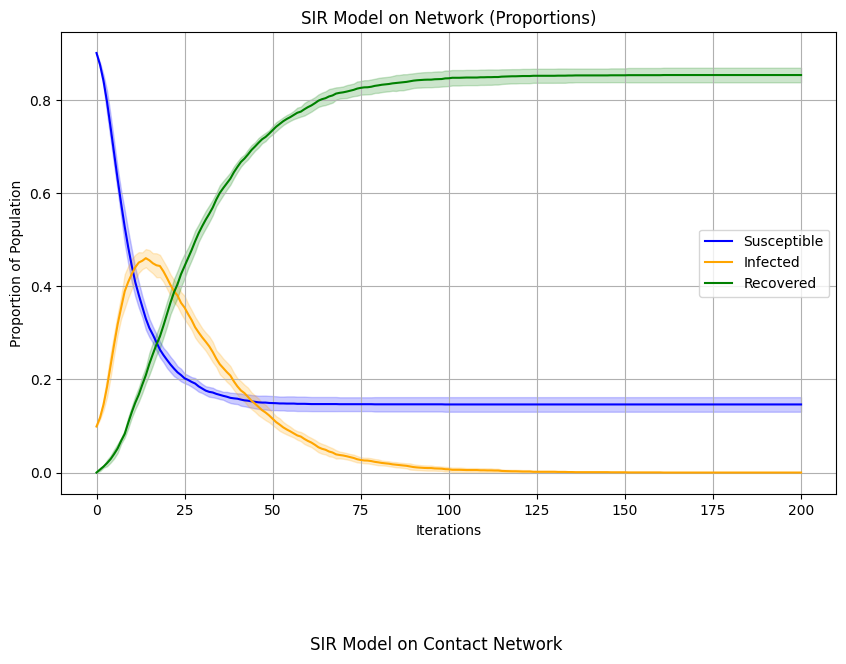

random


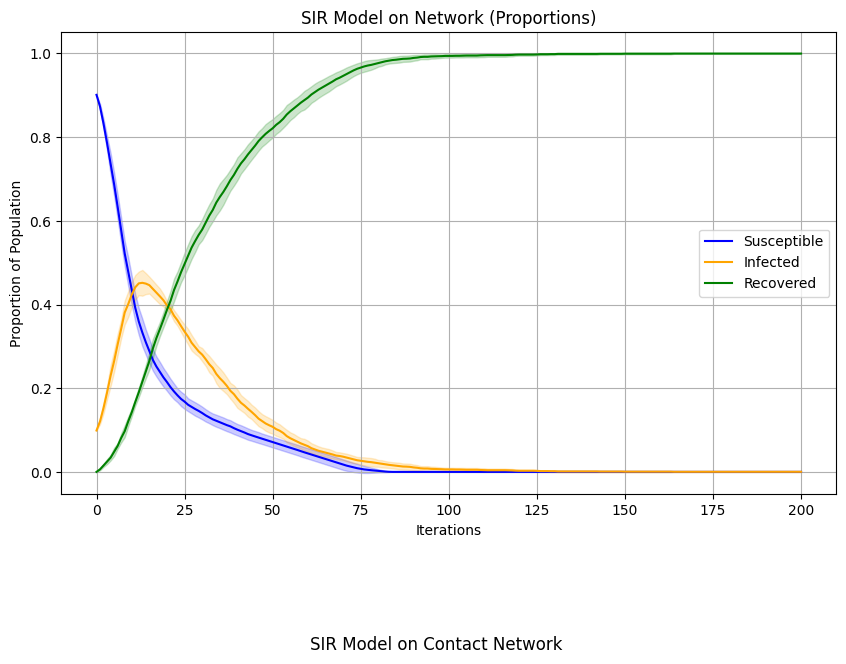

degree


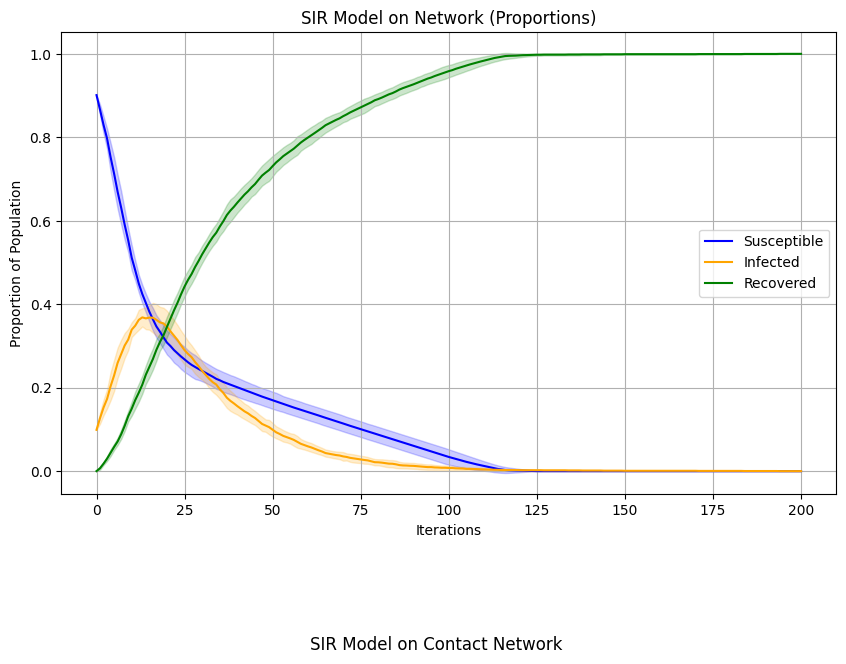

eigenvector


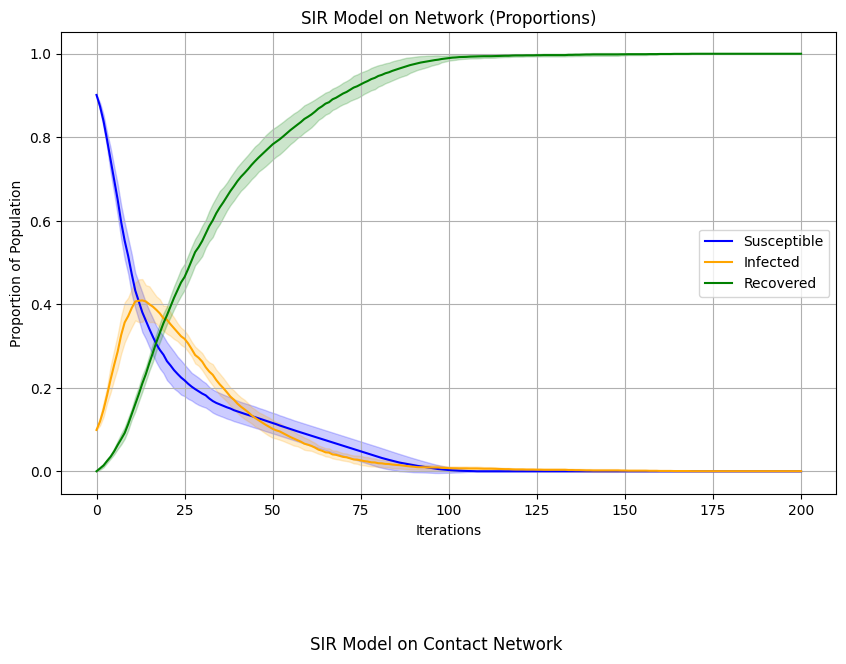

betweenness


KeyboardInterrupt: 

In [36]:
strategies = [None, "random", "degree", "eigenvector", "betweenness"]
testing_accuracies = [0.5, 0.75, 1.0]:
testing_budgets = [1, 3, 5, 10]:
vaccination_budgets = [1, 3, 5, 10]:

for strategy in strategies:
    for testing_accuracy in testing_accuracies:
        for testing_budget in testing_budgets:
            for vaccination_budget in vaccination_budgets:
                caption = 'Vacination strategy' + str(strategy) + ' with testing budget {test_budget}, test accuracy {test_accuracy}, vaccination budget {vaccination_budget}'
                print(strategy)
                simulate_sir_set_graph(G, beta=0.05, vaccination_strategy=strategy, vaccination_budget=10, caption=caption, num_runs=10, testing_mode = 'on', test_accuracy=0.8, test_budget=1)
    